# Back-Propagation Basics
---

> This post is written to be a *companion piece* to Chapter 4.8 of Christopher Bishop's seminal textbook: "Neural Networks for Pattern Recognition." Readers interested in building deeper intution of the capabilities and limitations of neural networks–as well as the governing mathematics of machine learning will benefit enoromously from a review of this classic treatment.

In our last blog post, we learned about the expressive power of **Multi-Layer Perceptions** (MLPs): feed-forward networks parameterized by weights and bias terms that apply sequential linear transformations to an input vector $\mathbf{x}$, with non-linear activation functions used at the output of each hidden layer. These remarkable models form an integral part of all modern deep learning architectures. But an MLP with randomly initialized parameters is completely useless to us, regardless of the structure, depth, and topology of the network. We want a highly general learning algorithm that applies to many different types of datasets, runs efficiently on modern computers, and learns to update model parameters using examples, opperating without oversight or instruction. 

This brings us to the topic of **Back-Propagation**: an efficient method for calculating the gradients of a neural network with respect to a loss function. Today, we will outline the high-level concepts and formal math underpining Backpropagation. In future posts, this foundation will allow us to analyize more complex methods of solving the so-called *credit assingment problem*, such as those leveraging paralleization or approximations. For now, all we ask is that the reader is familar with the basics of calculus–particularly gradients of multivariate functions and nested functions.

Now, let's get reaquianted with some notation from previous posts. Recall that a multi-layer net $\text{MLP}(\mathbf{x}) \mapsto \mathbf{y}$ maps an input vector $\mathbf{x} = [x_1, x_2, \dots, x_d]$ to an output vector $\mathbf{y} = [y_1, y_2, \dots, y_k]$. This model is composed of some number of "hidden" layers applied sequentially to the input sequence. For a hidden layer containing $j$ individual neurons, the **pre-activation** $a_j$ of a unit determined by the previous layer's **activations** $z_i$ can be expressed as

\begin{equation} \tag{1}
    a_j = \sum_i w_{ji}z_i.                                       
\end{equation}  

Here, $z_i = g(a_i)$, where $g(\cdot)$ is an **activation function** (e.g., tanh) and $b$ is a bias term. In previous posts, we introduced a neat notational trick that allows us to subsume $b_i$ into a weight vector $\mathbf{w}$, allowing us to cleanly visualize the first layer of an MLP like so.

<div align="center">
<img src="assets/img/ml-concepts/backprop/mlp_preact.png"style="max-height: 500px;" />
</div>

To set the parameters of any neural network, it is critical that we first formalized a model's ideal behavior. An **error function** $E$, (also refered to as a **loss function** or **objective function**) provides an quantitative measure of the quality of model's predictions. This function takes the general form $f: \mathbb{R}^k \mapsto \mathbb{R}$, mapping our model's output vector $\mathbf{y}$ to a scalar value typically called a **loss**. Another way to think of the value $E$ is as a score, which we sometimes want to maximize and sometimes wish to minize depending upon the task at hand. To take a concrete example, say our model took as input Apple's ticker price from the previous week $\mathbf{x}_{\text{apple}}$, and predicted as output share prices over the next week $\mathbf{y}_{\text{pred}}$. We could define a simple **mean squared error** (MSE) function for a model, where lower errors indicate better predictions.

$$
E_{\text{apple}} = \sqrt{(\mathbf{y}_{\text{pred}} - \mathbf{y}_{\text{actual}})^2}
$$

For reasons that we won't get into today, the MSE loss satisfies all the basic criteria required of *any* error functions. Namely, it is *convex* and *differentiable at all points*. Also importantly, it steers model behavior in the right direction by punishing incorrect predictions, and rewarding outputs which are closer to the ground truth. Let's ammend our previous visualization of an MLP to include this error function, which is always applied after the **forward pass** of a model propogates through to the output layer.

<div align="center">
<img src="assets/img/ml-concepts/backprop/mlp_w_error.png"style="max-height: 500px;" />
</div>

Given some input vector $\mathbf{x}$, we can calculate the forward pass through a neural network $\text{MLP}(\cdot)$ by applying (Eq. 1) and the formula for the activation of a neuron $z = g(a)$ sequentially (layer-by-layer). Notice that calculations are computed left-to-right, starting with the hidden layers and terminating with computation of the model's loss. The process shown in the animation below is known as **forward propagation**.

<div align="center">
<img src="assets/img/ml-concepts/backprop/forward_pass.gif"style="max-height: 500px;" />
</div>

Now we turn to the central problem of **credit assingment**: the task of computing the contribution of any given weight $w_{ji}$ with respect to the total error assigned to a model $E^n = \sum^{n} E^n$ for a dataset containing $n$ unique samples. Concretely, we wish to find $\frac{\partial E^n}{\partial w_{ji}}$ for all parameters in our model. To achieve this, we can leverage the fact that a neural network is essentially a set of nested, differentiable functions. Backpropagation, as the name suggests, is a process that begins at the output (right) of a neural network and works toward the input (left). This proceedure makes heavy use of the **chain rule**; recall from calculus the general form that given a nested funtion of the form $y=f(g(x))$, we can find the derivative of outer function like so.

$$
    \frac{dy}{dx} = f'(g(x)) * f(g'(x)).
$$

Applying the chain rule to our neural network, we can calculate individual weight gradients as the product of the change in error w.r.t. a preactivation and the change in a preactivation w.r.t. the weight of interest.

\begin{equation} \tag{2}
    \frac{\partial E^n}{\partial w_{ji}} =
    \frac{\partial E^n}{\partial a_j}  *
    \frac{\partial a_j}{\partial w_{ji}}                                       
\end{equation}

Here, the value $\delta_j$ is referred to as the **error**. One can also picture this application of the chain rule pictorally. All neural nets are really just a big directed acyclic graph? One can intuit that, given an arrow pointing from $\text{node}_c \rightarrow \text{node}_a$ representing $\frac{\partial \text{node}_c}{\partial \text{node}_a}$, and another $\text{node}_{b}$ lying on the path between them, one can visually observe

\begin{align*}
    \frac{\partial \text{node}_c}{\partial \text{node}_a} =
    \frac{\partial \text{node}_c}{\partial \text{node}_b}  *
    \frac{\partial \text{node}_b}{\partial \text{node}_a} 
\end{align*}.

<div align="center">
<img src="assets/img/ml-concepts/backprop/backwards_inuit.png"style="max-height: 300px;" />
</div>

% TODO: create a pictoral diagram showing the chain rule in action for the equation above, and the general intution that graidents of sequential functions can be composed using multiplication.

\begin{align*}
    \frac{\partial a_j}{\partial w_{ji}} &= \frac{\partial}{\partial w_{ji}} \Big( \sum_i w_{ji} z_{i} \Big) \\
    &= \frac{\partial}{\partial w_{ji}} \Big( \cancel{w_{j0} z_{0}} + \cancel{w_{j1} z_{1}} + \dots + w_{ji} z_{i} \Big) \\
    &= z_i
\end{align*}

\begin{equation} \tag{3}
    \frac{\partial E^n}{\partial w_{ji}} =
    \delta_j z_i                                    
\end{equation}

\begin{equation} \tag{4}
    \delta_k \equiv
    \frac{\partial E^n}{\partial a_k} =
    g'(a_k) \frac{\partial E^n}{\partial y_k}
\end{equation}

\begin{equation} \tag{5}
    \delta_j \equiv
    \frac{\partial E^n}{\partial a_j} =
    \sum_{k} \frac{\partial E^n}{\partial a_k} \frac{\partial a_k}{\partial a_j}
\end{equation}

\begin{equation} \tag{6}
    \delta_j = g'(a_j) \sum_{k} w_{kj} \delta_k
\end{equation}

Backpropagation
1. For a vector input $\mathbf{x}$ and a neural network $\text{MLP}$, perform a **forward pass** to calculate all activations $z$ in the hidden and output layer.
2. Use (Eq. 4) to calculate all $\delta_k$ in the output layer.
3. "Backpropagate $\delta \text{'s}$ to calculate all $\delta_j$".
4. Evalulate (Eq. 3) at all weights.

\begin{equation} \tag{7}
    \frac{\partial E}{w_{ji}} = \sum_{n} \frac{\partial E^n}{\partial w_{ji}}
\end{equation}

---

Recall that an MLP and indeed all neural networks can be expressed in formal mathematical notation; consider the general forumla for a network with one hidden layer using the tanh activation function:

1. error functions
    - L2; RSME; sum of least squares
2. motivation for an optimization proceedure for hidden units
    - "credit assignment problem"
    - when entire network is differentiable, can calculate change in loss wrt to change in any weight/bias term (derivative).
3. backprop: algo that finds partials of weights wrt loss
    - "computationally efficient method for calculating grads"


### Notes

- 4.30
    - 


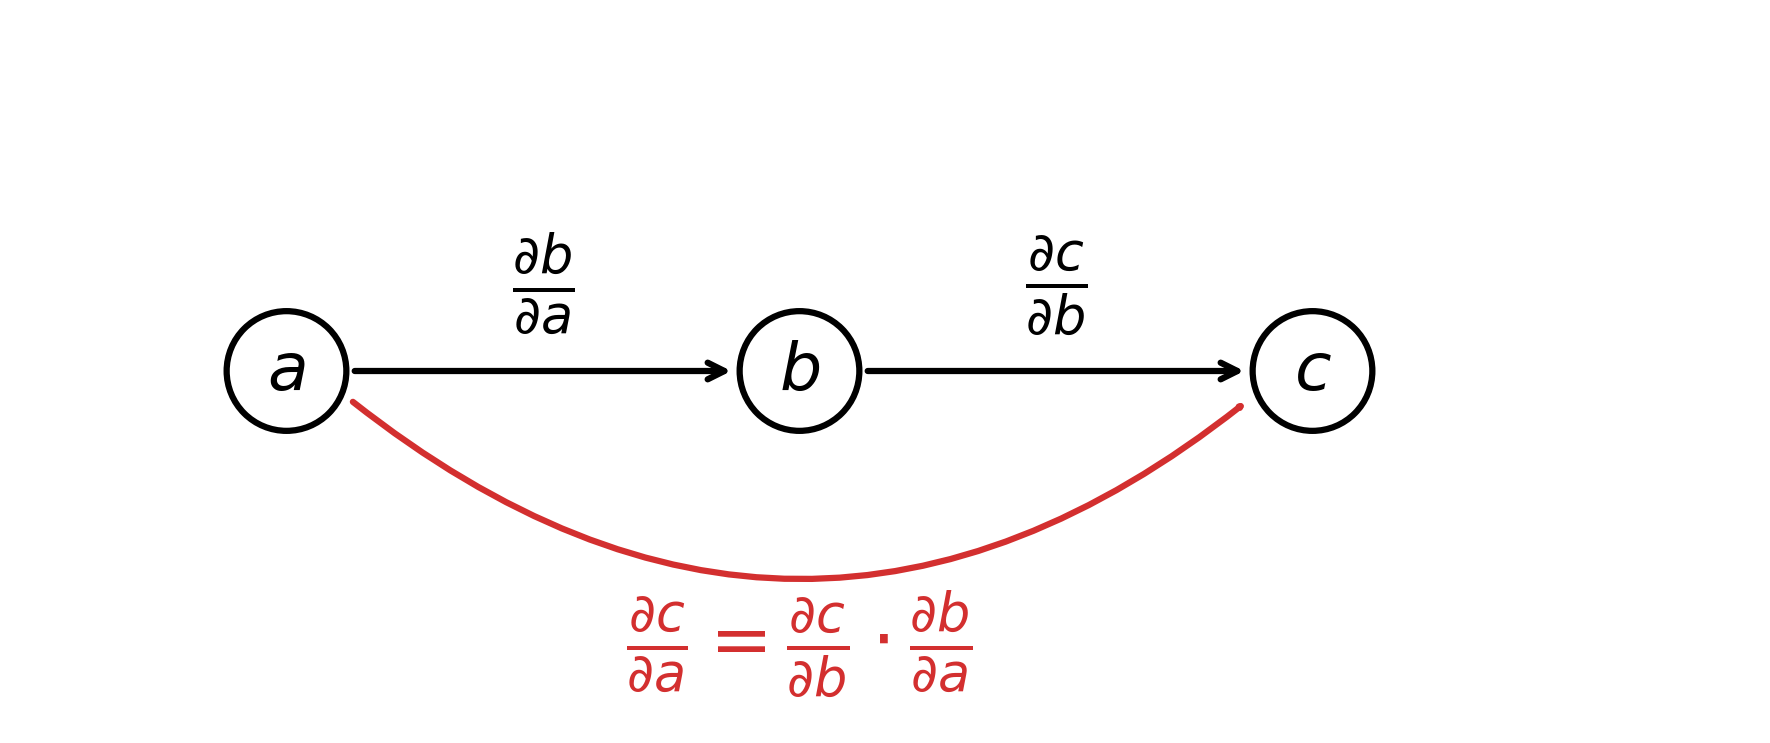

In [29]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), dpi=300)
ax.set_xlim(-1, 9)
ax.set_ylim(-1.5, 2.5)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35  # node radius

# --- Node positions (horizontal line) ---
ax_pos = (0.5, 0.5)
bx_pos = (3.5, 0.5)
cx_pos = (6.5, 0.5)

# --- Helper: draw a circle with text ---
def draw_node(x, y, text, fontsize=16):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

# --- Draw nodes ---
draw_node(*ax_pos, r'$a$')
draw_node(*bx_pos, r'$b$')
draw_node(*cx_pos, r'$c$')

# --- Straight arrows: a -> b and b -> c ---
ax.annotate('', xy=(bx_pos[0] - r, bx_pos[1]), xytext=(ax_pos[0] + r, ax_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax.annotate('', xy=(cx_pos[0] - r, cx_pos[1]), xytext=(bx_pos[0] + r, bx_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

# --- Labels on straight arrows ---
ax.text(2.0, 0.7, r'$\frac{\partial b}{\partial a}$',
        ha='center', va='bottom', fontsize=18)
ax.text(5.0, 0.7, r'$\frac{\partial c}{\partial b}$',
        ha='center', va='bottom', fontsize=18)

# --- Curved arrow: a -> c (underneath) ---
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches

arc = FancyArrowPatch(
    (ax_pos[0] + r, ax_pos[1] - 0.15),
    (cx_pos[0] - r, cx_pos[1] - 0.15),
    connectionstyle="arc3,rad=0.4",
    arrowstyle='->', color='#D32F2F', lw=1.5, zorder=2
)
ax.add_patch(arc)

# --- Label on curved arrow ---
ax.text(3.5, -1.1, r'$\frac{\partial c}{\partial a} = \frac{\partial c}{\partial b} \cdot \frac{\partial b}{\partial a}$',
        ha='center', va='center', fontsize=18, color='#D32F2F')

plt.tight_layout()
plt.show()

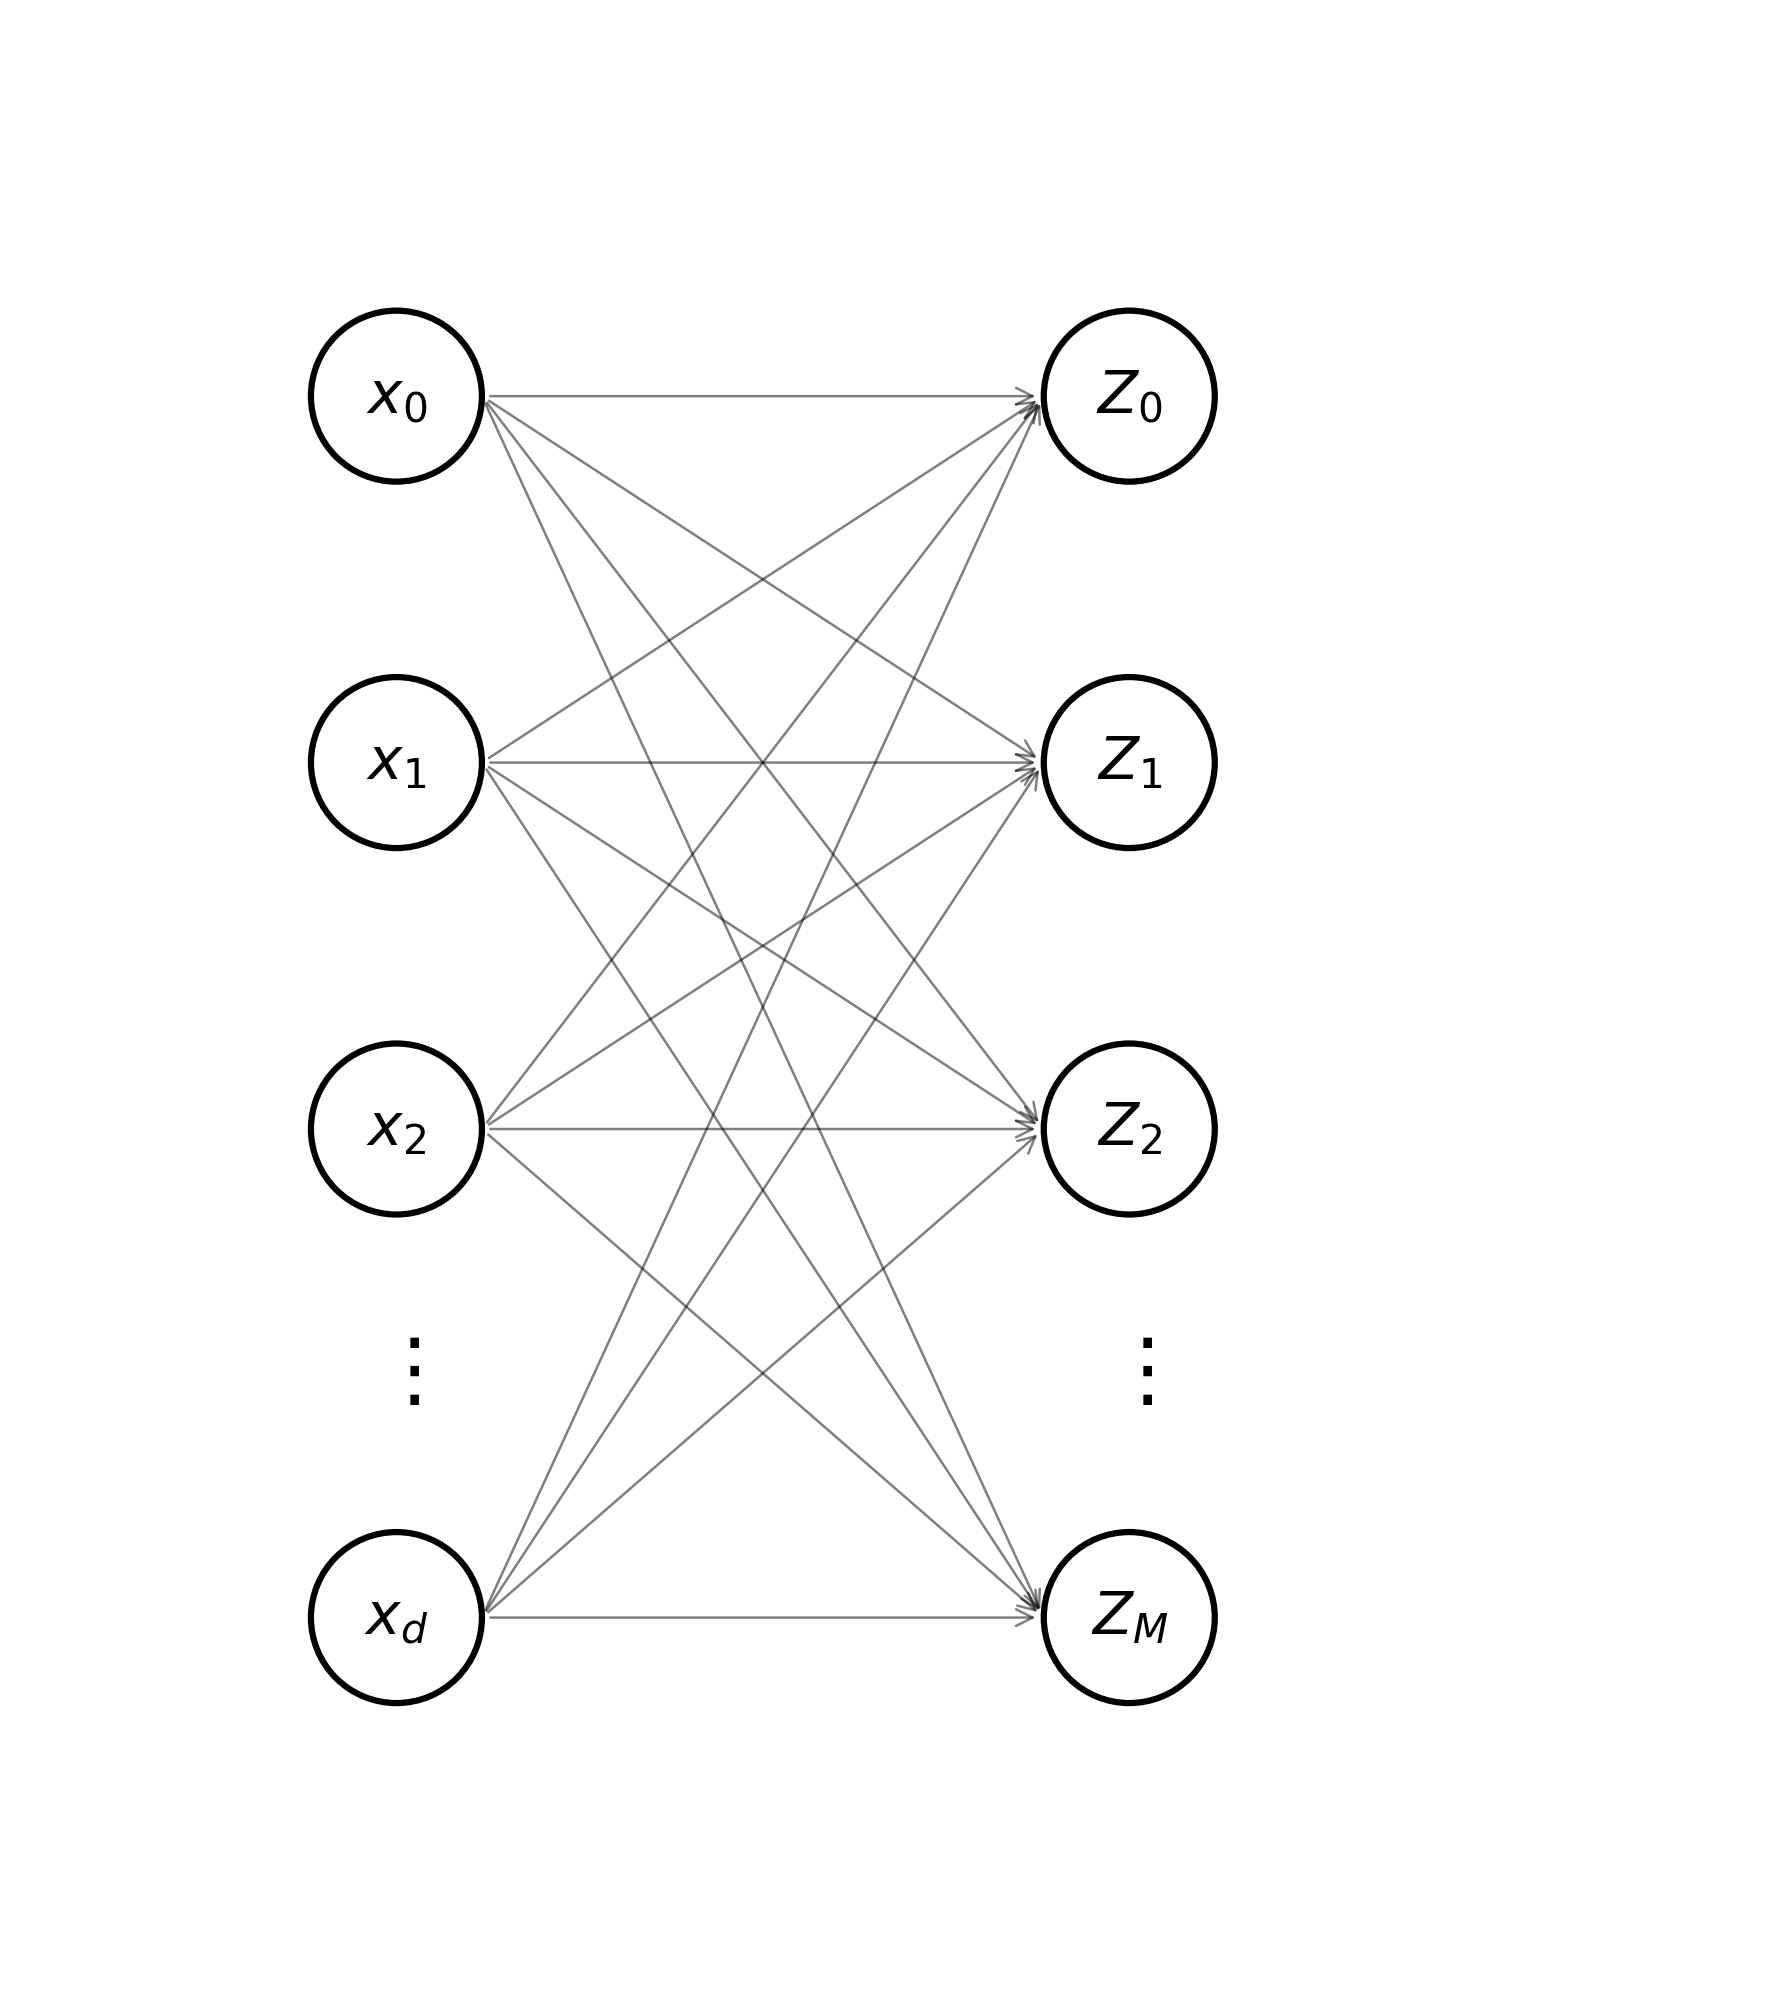

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(6, 8), dpi=300)
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 7)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35  # node radius

# --- Positions ---
input_x = 0.5
z_x = 3.5

input_ys  = [5.5, 4.0, 2.5, 0.5]   # x0, x1, x2, xd
z_ys      = [5.5, 4.0, 2.5, 0.5]   # Z0, Z1, Z2, ZM

# --- Helper: draw a circle with text ---
def draw_node(x, y, text, fontsize=14):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

# --- Draw input nodes ---
input_labels = [r'$x_0$', r'$x_1$', r'$x_2$', r'$x_d$']
for y, label in zip(input_ys, input_labels):
    draw_node(input_x, y, label)
ax.text(input_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw hidden (Z) nodes ---
z_labels = [r'$Z_0$', r'$Z_1$', r'$Z_2$', r'$Z_M$']
for y, label in zip(z_ys, z_labels):
    draw_node(z_x, y, label)
ax.text(z_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Connections: input -> Z (all-to-all, fully connected) ---
for iy in input_ys:
    for zy in z_ys:
        ax.annotate('', xy=(z_x - r, zy), xytext=(input_x + r, iy),
                    arrowprops=dict(arrowstyle='->', color='black', lw=0.6, alpha=0.5))

plt.tight_layout()
plt.show()

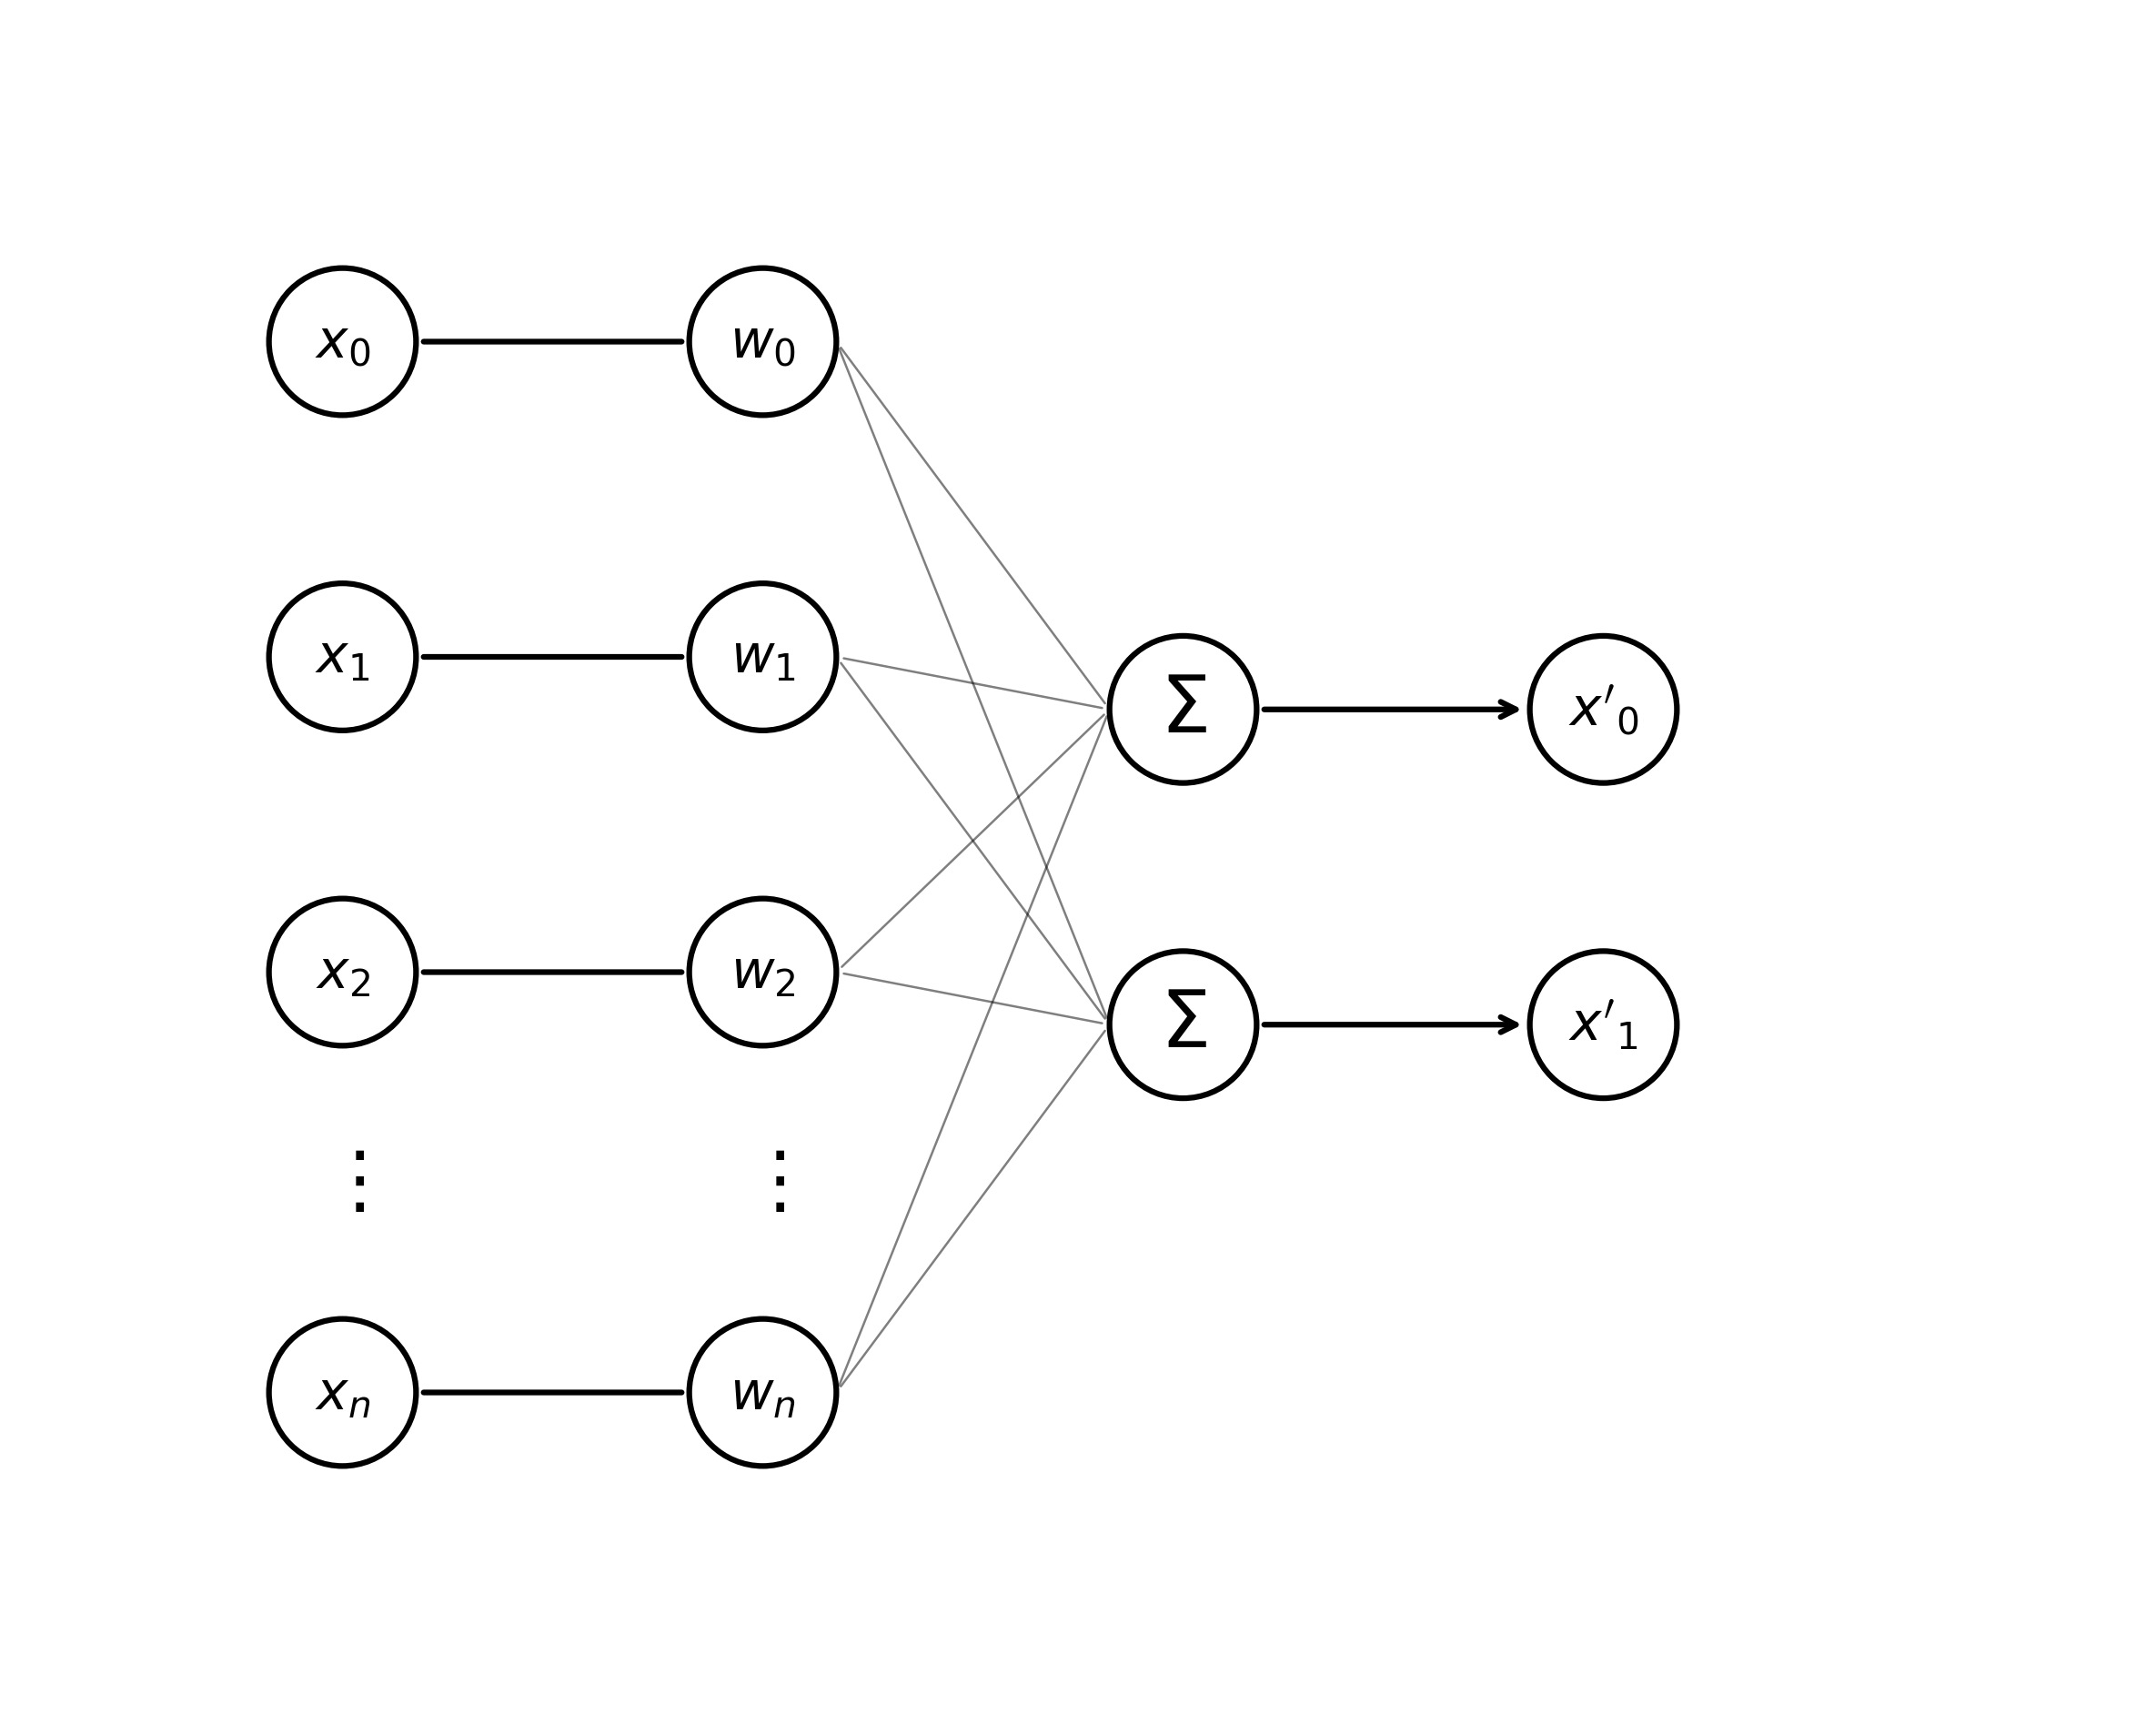

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
ax.set_xlim(-1, 9)
ax.set_ylim(-1, 7)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35  # node radius

# --- Positions ---
input_x = 0.5
weight_x = 2.5
sum_x = 4.5
out_x = 6.5

input_ys  = [5.5, 4.0, 2.5, 0.5]   # x0, x1, x2, xn
weight_ys = [5.5, 4.0, 2.5, 0.5]   # w0, w1, w2, wn
output_ys = [3.75, 2.25]             # x'0, x'1
sum_ys    = [3.75, 2.25]             # one summation per output

# --- Helper: draw a circle with text ---
def draw_node(x, y, text, fontsize=14):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

# --- Draw input nodes ---
input_labels = [r'$x_0$', r'$x_1$', r'$x_2$', r'$x_n$']
for y, label in zip(input_ys, input_labels):
    draw_node(input_x, y, label)
ax.text(input_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw weight nodes ---
weight_labels = [r'$w_0$', r'$w_1$', r'$w_2$', r'$w_n$']
for y, label in zip(weight_ys, weight_labels):
    draw_node(weight_x, y, label)
ax.text(weight_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw summation nodes ---
for y in sum_ys:
    draw_node(sum_x, y, r'$\Sigma$', fontsize=21)

# --- Draw output nodes ---
output_labels = [r"$x'_0$", r"$x'_1$"]
for y, label in zip(output_ys, output_labels):
    draw_node(out_x, y, label)

# --- Connections: input -> weight (one-to-one) ---
for iy, wy in zip(input_ys, weight_ys):
    ax.annotate('', xy=(weight_x - r, wy), xytext=(input_x + r, iy),
                arrowprops=dict(arrowstyle='-', color='black', lw=1.5))

# --- Connections: weight -> summation (all-to-all, fully connected) ---
for wy in weight_ys:
    for sy in sum_ys:
        ax.annotate('', xy=(sum_x - r, sy), xytext=(weight_x + r, wy),
                    arrowprops=dict(arrowstyle='-', color='black', lw=0.6, alpha=0.5))

# --- Connections: summation -> output (one-to-one) ---
for sy, oy in zip(sum_ys, output_ys):
    ax.annotate('', xy=(out_x - r, oy), xytext=(sum_x + r, sy),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

plt.tight_layout()
plt.show()

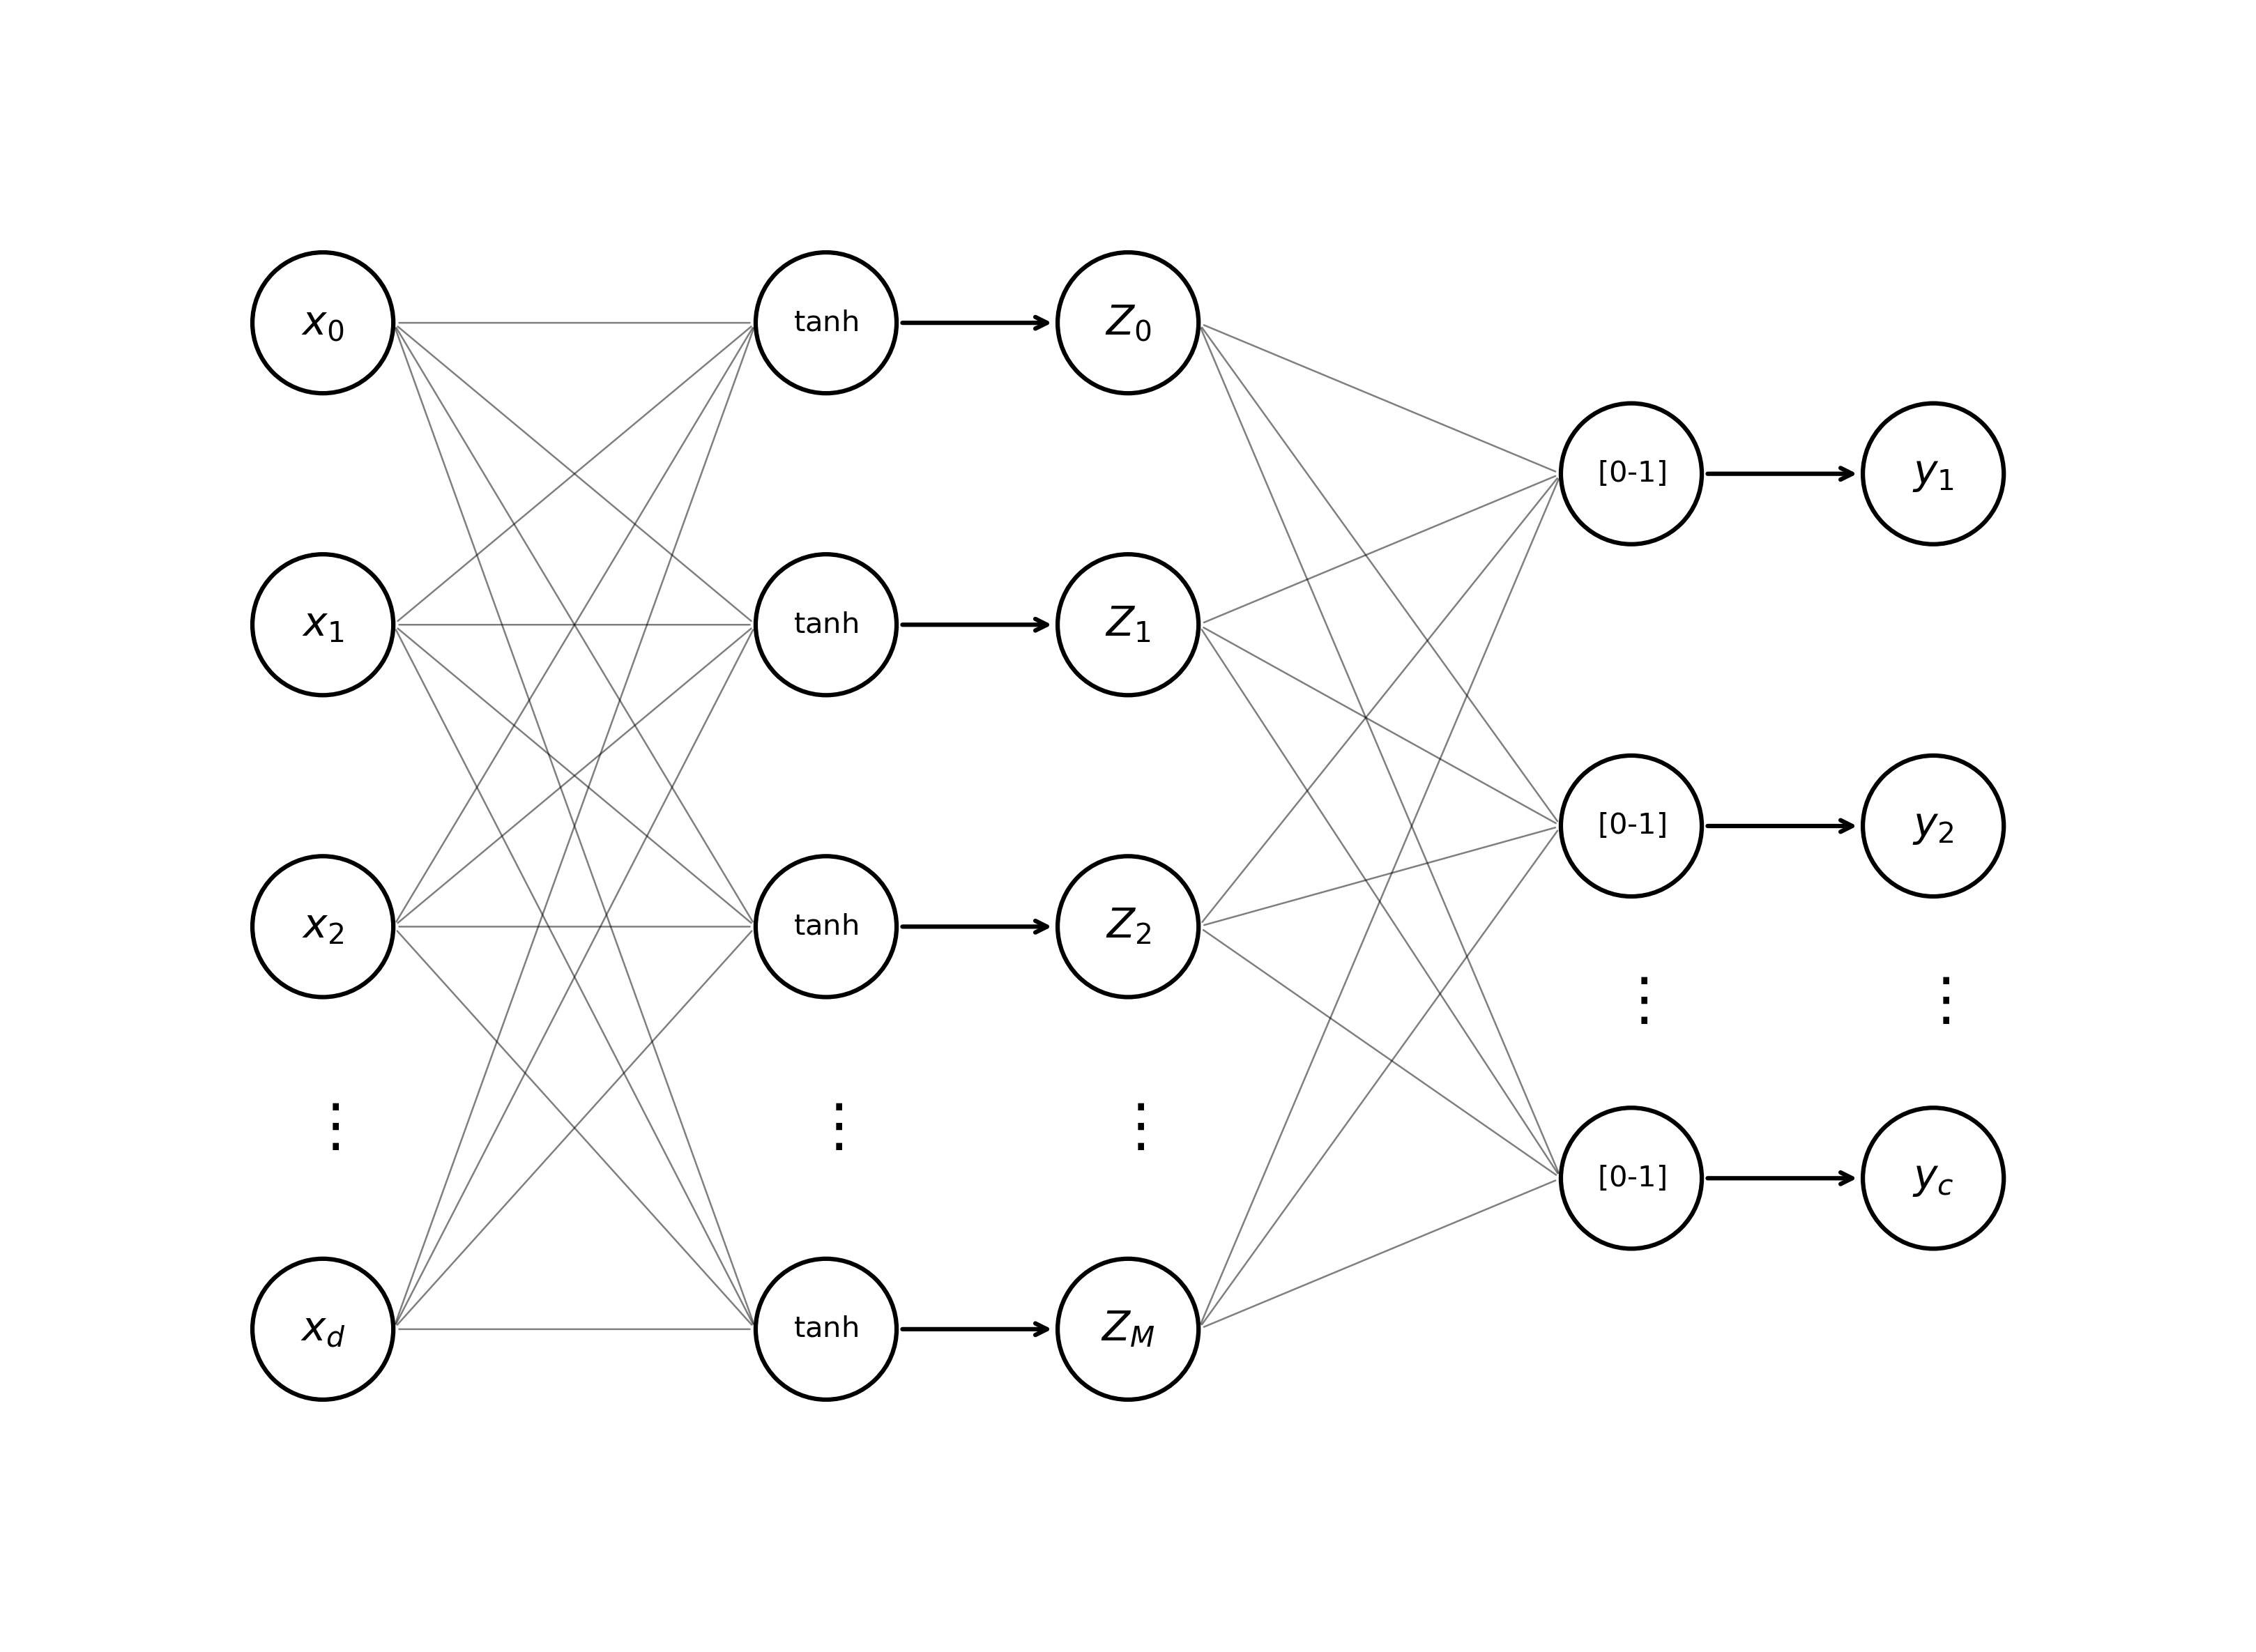

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
ax.set_xlim(-1, 10)
ax.set_ylim(-1, 7)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35  # node radius

# --- Positions ---
input_x = 0.5
tanh_x = 3.0
z_x = 4.5
sig_x = 7.0
out_x = 8.5

input_ys = [5.5, 4.0, 2.5, 0.5]       # x0, x1, x2, xd
tanh_ys  = [5.5, 4.0, 2.5, 0.5]       # tanh nodes
z_ys     = [5.5, 4.0, 2.5, 0.5]       # Z0, Z1, Z2, ZM
sig_ys   = [4.75, 3.0, 1.25]           # [0-1] nodes
out_ys   = [4.75, 3.0, 1.25]           # y1, y2, yc

# --- Helper: draw a circle with text ---
def draw_node(x, y, text, fontsize=14):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

# --- Draw input nodes ---
input_labels = [r'$x_0$', r'$x_1$', r'$x_2$', r'$x_d$']
for y, label in zip(input_ys, input_labels):
    draw_node(input_x, y, label)
ax.text(input_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw tanh nodes ---
for y in tanh_ys:
    draw_node(tanh_x, y, r'$\tanh$', fontsize=10)
ax.text(tanh_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw hidden (Z) nodes ---
z_labels = [r'$Z_0$', r'$Z_1$', r'$Z_2$', r'$Z_M$']
for y, label in zip(z_ys, z_labels):
    draw_node(z_x, y, label)
ax.text(z_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw [0-1] nodes ---
for y in sig_ys:
    draw_node(sig_x, y, r'$[0\text{-}1]$', fontsize=10)
ax.text(sig_x, 2.125, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw output nodes ---
out_labels = [r'$y_1$', r'$y_2$', r'$y_c$']
for y, label in zip(out_ys, out_labels):
    draw_node(out_x, y, label)
ax.text(out_x, 2.125, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Connections: input -> tanh (all-to-all) ---
for iy in input_ys:
    for ty in tanh_ys:
        ax.annotate('', xy=(tanh_x - r, ty), xytext=(input_x + r, iy),
                    arrowprops=dict(arrowstyle='-', color='black', lw=0.6, alpha=0.5))

# --- Connections: tanh -> Z (one-to-one) ---
for ty, zy in zip(tanh_ys, z_ys):
    ax.annotate('', xy=(z_x - r, zy), xytext=(tanh_x + r, ty),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

# --- Connections: Z -> [0-1] (all-to-all) ---
for zy in z_ys:
    for sy in sig_ys:
        ax.annotate('', xy=(sig_x - r, sy), xytext=(z_x + r, zy),
                    arrowprops=dict(arrowstyle='-', color='black', lw=0.6, alpha=0.5))

# --- Connections: [0-1] -> y (one-to-one) ---
for sy, oy in zip(sig_ys, out_ys):
    ax.annotate('', xy=(out_x - r, oy), xytext=(sig_x + r, sy),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

plt.tight_layout()
plt.show()

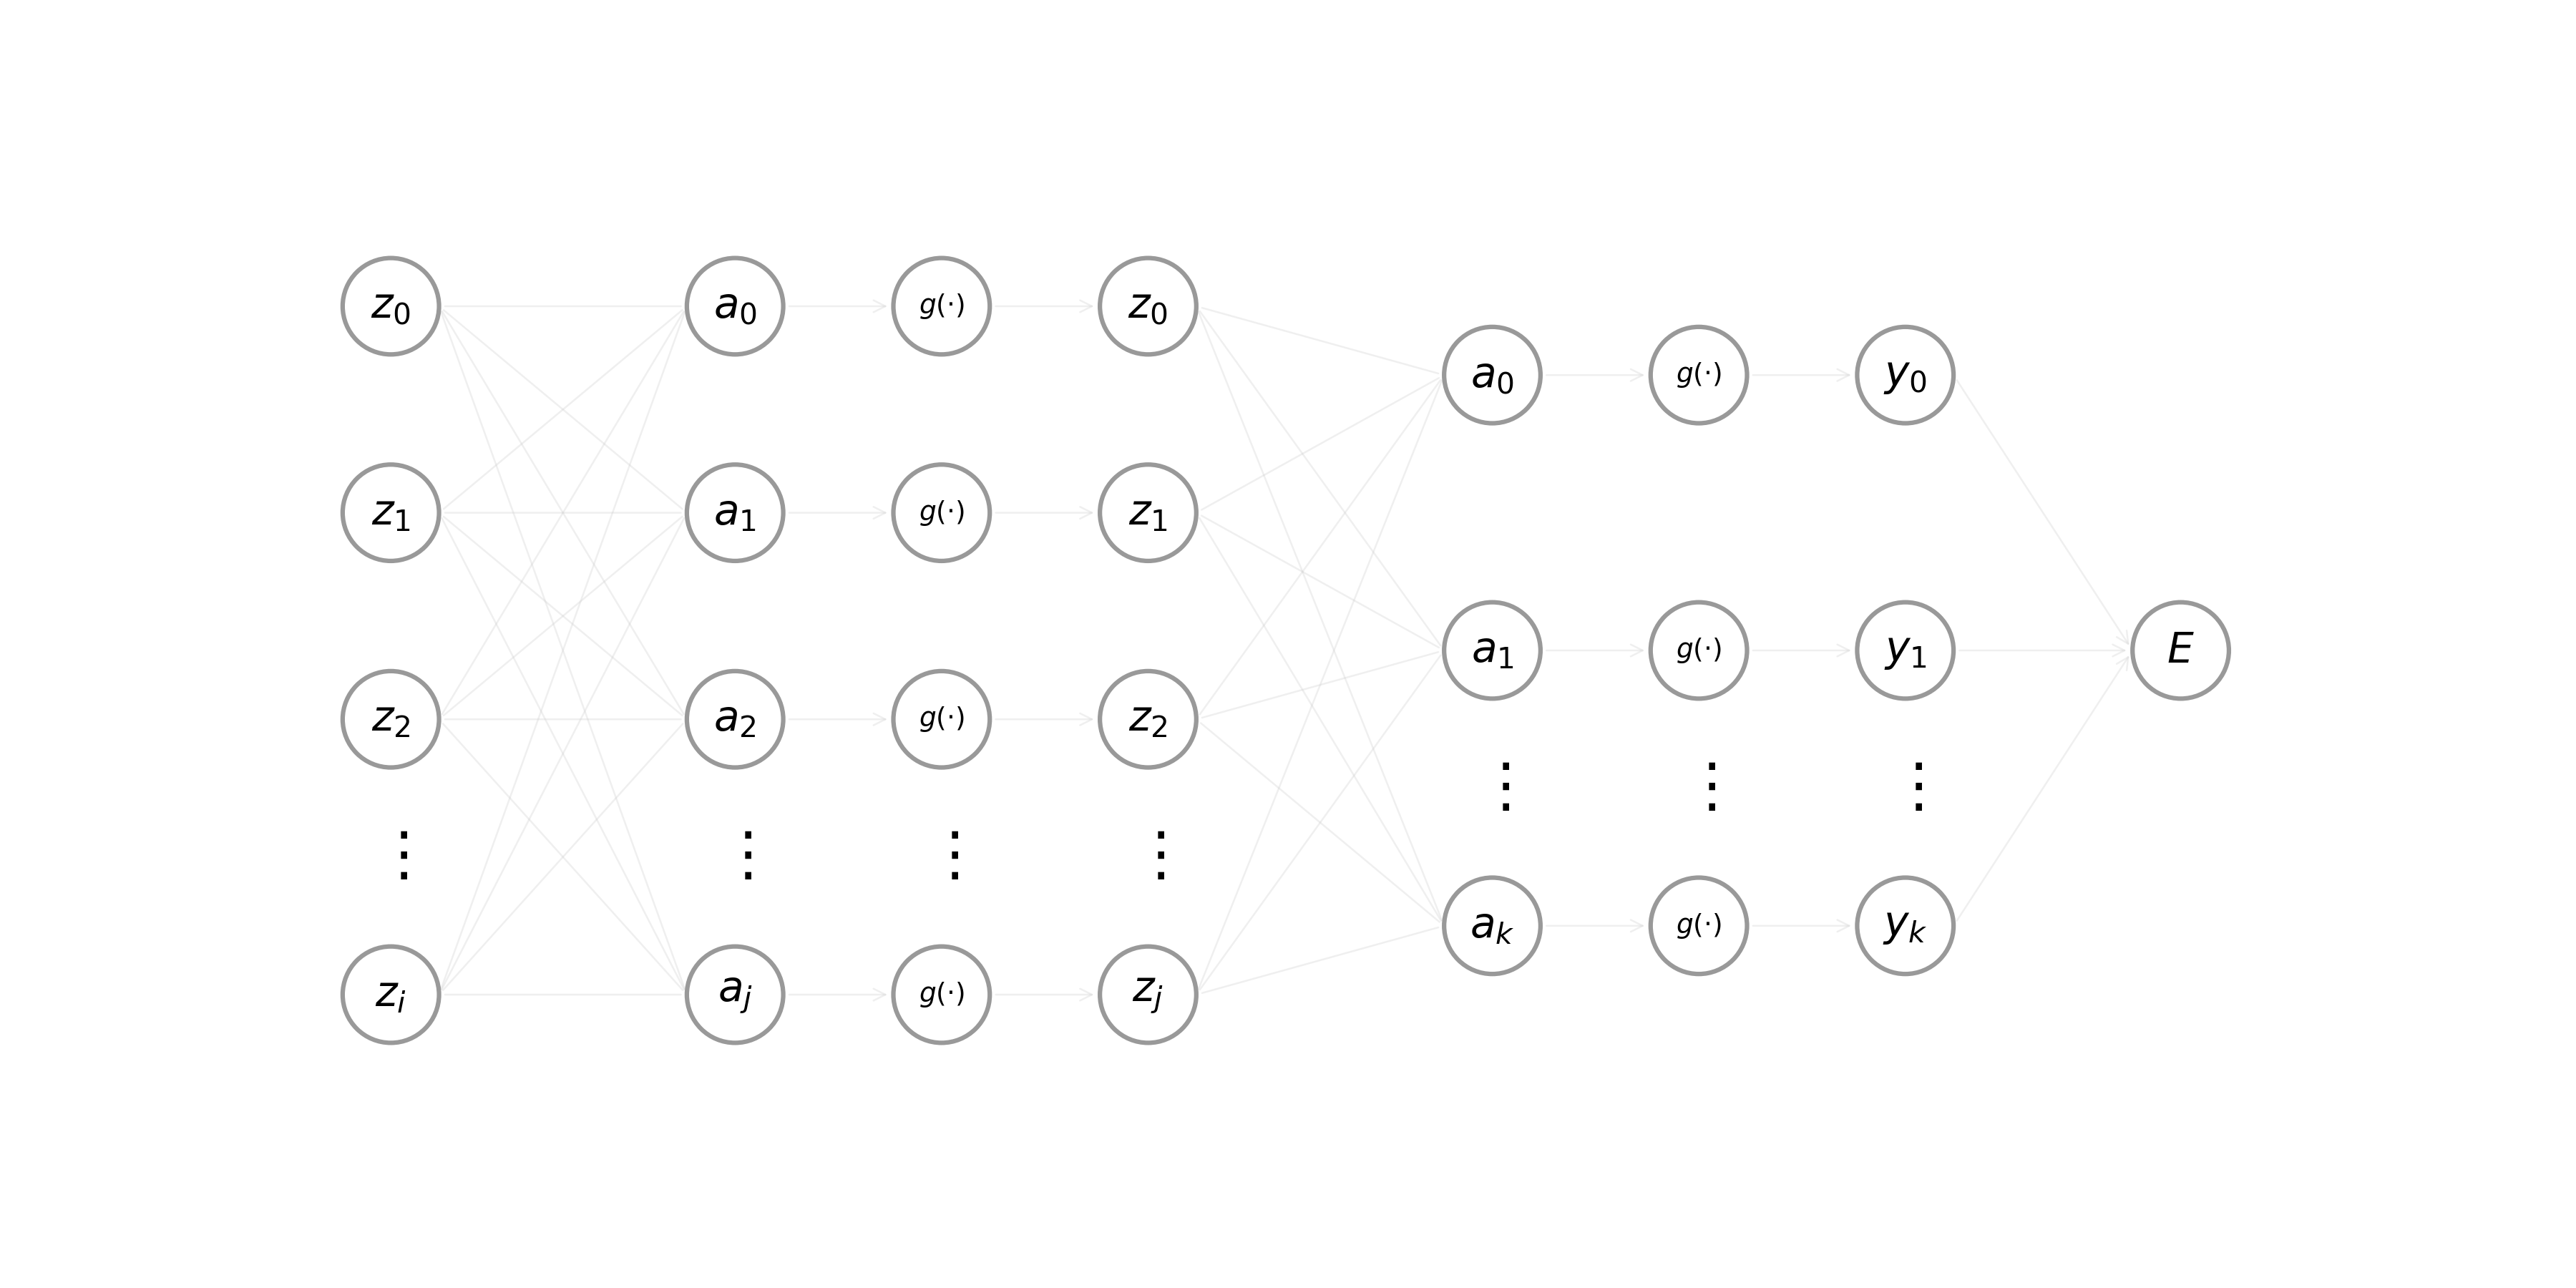

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import Image, display

# ── Forward-pass computation ─────────────────────────────
np.random.seed(42)
z_in = np.array([0.50, -0.30, 0.80, 0.10])
W1 = np.array([[ 0.50, -0.20,  0.30,  0.10],
                [-0.40,  0.60,  0.10, -0.30],
                [ 0.20,  0.10, -0.50,  0.40],
                [ 0.30, -0.10,  0.20, -0.20]])
a_hid = W1 @ z_in
z_hid = np.tanh(a_hid)

W2 = np.array([[ 0.40, -0.30,  0.20,  0.10],
                [-0.20,  0.50,  0.30, -0.10],
                [ 0.10,  0.20, -0.40,  0.30]])
a_out = W2 @ z_hid
y_out = np.tanh(a_out)
target = np.array([1.0, 0.0, 0.0])
E_val = 0.5 * np.sum((y_out - target) ** 2)

# ── Layout (same positions as original static diagram) ───
r = 0.35

col_x = {
    'input': 0.5, 'a1': 3.0, 'g1': 4.5, 'z': 6.0,
    'a2': 8.5, 'g2': 10.0, 'y': 11.5, 'E': 13.5,
}
col_ys = {
    'input': [5.5, 4.0, 2.5, 0.5],
    'a1':    [5.5, 4.0, 2.5, 0.5],
    'g1':    [5.5, 4.0, 2.5, 0.5],
    'z':     [5.5, 4.0, 2.5, 0.5],
    'a2':    [5.0, 3.0, 1.0],
    'g2':    [5.0, 3.0, 1.0],
    'y':     [5.0, 3.0, 1.0],
    'E':     [3.0],
}
col_labels = {
    'input': [r'$z_0$', r'$z_1$', r'$z_2$', r'$z_i$'],
    'a1':    [r'$a_0$', r'$a_1$', r'$a_2$', r'$a_j$'],
    'g1':    [r'$g(\cdot)$'] * 4,
    'z':     [r'$z_0$', r'$z_1$', r'$z_2$', r'$z_j$'],
    'a2':    [r'$a_0$', r'$a_1$', r'$a_k$'],
    'g2':    [r'$g(\cdot)$'] * 3,
    'y':     [r'$y_0$', r'$y_1$', r'$y_k$'],
    'E':     [r'$E$'],
}
col_values = {
    'input': z_in, 'a1': a_hid, 'g1': None, 'z': z_hid,
    'a2': a_out, 'g2': None, 'y': y_out, 'E': np.array([E_val]),
}
col_fs = {
    'input': 14, 'a1': 14, 'g1': 9, 'z': 14,
    'a2': 14, 'g2': 9, 'y': 14, 'E': 14,
}
vdots = {
    'input': (0.5, 1.5), 'a1': (3.0, 1.5), 'g1': (4.5, 1.5),
    'z': (6.0, 1.5), 'a2': (8.5, 2.0), 'g2': (10.0, 2.0),
    'y': (11.5, 2.0),
}

# Edge groups: (source_col, target_col, connection_type, arrowstyle)
edges = {
    'in_a1':  ('input', 'a1', 'all',     '-'),
    'a1_g1':  ('a1',    'g1', 'one',     '->'),
    'g1_z':   ('g1',    'z',  'one',     '->'),
    'z_a2':   ('z',     'a2', 'all',     '-'),
    'a2_g2':  ('a2',    'g2', 'one',     '->'),
    'g2_y':   ('g2',    'y',  'one',     '->'),
    'y_E':    ('y',     'E',  'all_one', '->'),
}

# ── Animation stages ─────────────────────────────────────
# (completed_set, active_col, active_edge_set, description)
stages = [
    (set(),                                         None,  set(),         ''),
    ({'input'},                                     'input', set(),       r'Input activations $z_i$'),
    ({'input'},                                     'a1',  {'in_a1'},     r'Pre-activations $a_j = \sum_i w_{ji}\, z_i$'),
    ({'input', 'a1'},                               'g1',  {'a1_g1'},     r'Activation function $g(\cdot)$'),
    ({'input', 'a1', 'g1'},                         'z',   {'g1_z'},      r'Hidden activations $z_j = g(a_j)$'),
    ({'input', 'a1', 'g1', 'z'},                    'a2',  {'z_a2'},      r'Pre-activations $a_k = \sum_j w_{kj}\, z_j$'),
    ({'input', 'a1', 'g1', 'z', 'a2'},              'g2',  {'a2_g2'},     r'Activation function $g(\cdot)$'),
    ({'input', 'a1', 'g1', 'z', 'a2', 'g2'},        'y',   {'g2_y'},      r'Output $y_k = g(a_k)$'),
    ({'input', 'a1', 'g1', 'z', 'a2', 'g2', 'y'},   'E',   {'y_E'},       r'Error $E = \frac{1}{2}\sum_k (y_k - t_k)^2$'),
    ({'input', 'a1', 'g1', 'z', 'a2', 'g2', 'y', 'E'}, None, set(),      'Done!'),
]

# Colors
C_INACTIVE  = '#FFFFFF'
C_ACTIVE    = '#FFB74D'
C_DONE      = '#81C784'
C_EDGE_OFF  = '#CCCCCC'
C_EDGE_ON   = '#FF7043'
C_VALUE     = '#1565C0'

# ── Drawing ──────────────────────────────────────────────
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)

def draw_frame(frame_idx):
    ax.clear()
    ax.set_xlim(0, 14.5)
    ax.set_ylim(0, 6.0)
    ax.set_aspect('equal')
    ax.axis('off')

    completed, active, active_edges, desc = stages[min(frame_idx, len(stages) - 1)]

    # Stage label
    ax.text(7.0, 6.7, desc, ha='center', va='center', fontsize=16)

    # Draw edges
    for ename, (src, tgt, conn, astyle) in edges.items():
        sx, tx = col_x[src], col_x[tgt]
        sys_, tys = col_ys[src], col_ys[tgt]

        is_active = ename in active_edges
        both_done = src in completed and tgt in completed
        color = C_EDGE_ON if is_active else ('#AAAAAA' if both_done else C_EDGE_OFF)
        alpha = 0.8 if is_active else (0.45 if both_done else 0.3)
        lw = 1.5 if is_active else 0.6

        pairs = []
        if conn == 'all':
            pairs = [(sy, ty) for sy in sys_ for ty in tys]
        elif conn == 'one':
            pairs = list(zip(sys_, tys))
        elif conn == 'all_one':
            pairs = [(sy, tys[0]) for sy in sys_]

        for sy, ty in pairs:
            ax.annotate('', xy=(tx - r, ty), xytext=(sx + r, sy),
                        arrowprops=dict(arrowstyle=astyle, color=color, lw=lw, alpha=alpha))

    # Draw nodes
    for cname in col_x:
        x = col_x[cname]
        ys = col_ys[cname]
        labels = col_labels[cname]
        values = col_values[cname]
        fs = col_fs[cname]

        if cname in completed:
            fc, ec = C_DONE, '#388E3C'
        elif cname == active:
            fc, ec = C_ACTIVE, '#E65100'
        else:
            fc, ec = C_INACTIVE, '#999999'

        for i, (y, label) in enumerate(zip(ys, labels)):
            circ = plt.Circle((x, y), r, facecolor=fc, edgecolor=ec, linewidth=1.5, zorder=3)
            ax.add_patch(circ)
            ax.text(x, y, label, ha='center', va='center', fontsize=fs, zorder=4)

            # Numerical value below node
            if values is not None and (cname in completed or cname == active):
                ax.text(x, y - r - 0.18, f'{values[i]:.2f}', ha='center', va='top',
                        fontsize=8, color=C_VALUE, fontweight='bold', zorder=4,
                        bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.7, linewidth=0))

    # Vertical dots
    for cname, (vx, vy) in vdots.items():
        ax.text(vx, vy, r'$\vdots$', ha='center', va='center', fontsize=20)

# Duplicate frames to slow the animation (hold each stage ~1.5 s)
frame_seq = []
for i in range(len(stages)):
    hold = 4 if i == len(stages) - 1 else 2  # hold final frame longer
    frame_seq.extend([i] * hold)

anim = animation.FuncAnimation(fig, lambda f: draw_frame(frame_seq[f]),
                                frames=len(frame_seq), repeat=True)
gif_path = 'assets/img/ml-concepts/backprop/forward_pass.gif'
anim.save(gif_path, writer='pillow', fps=0.5, dpi=300)
plt.close()

display(Image(filename=gif_path))

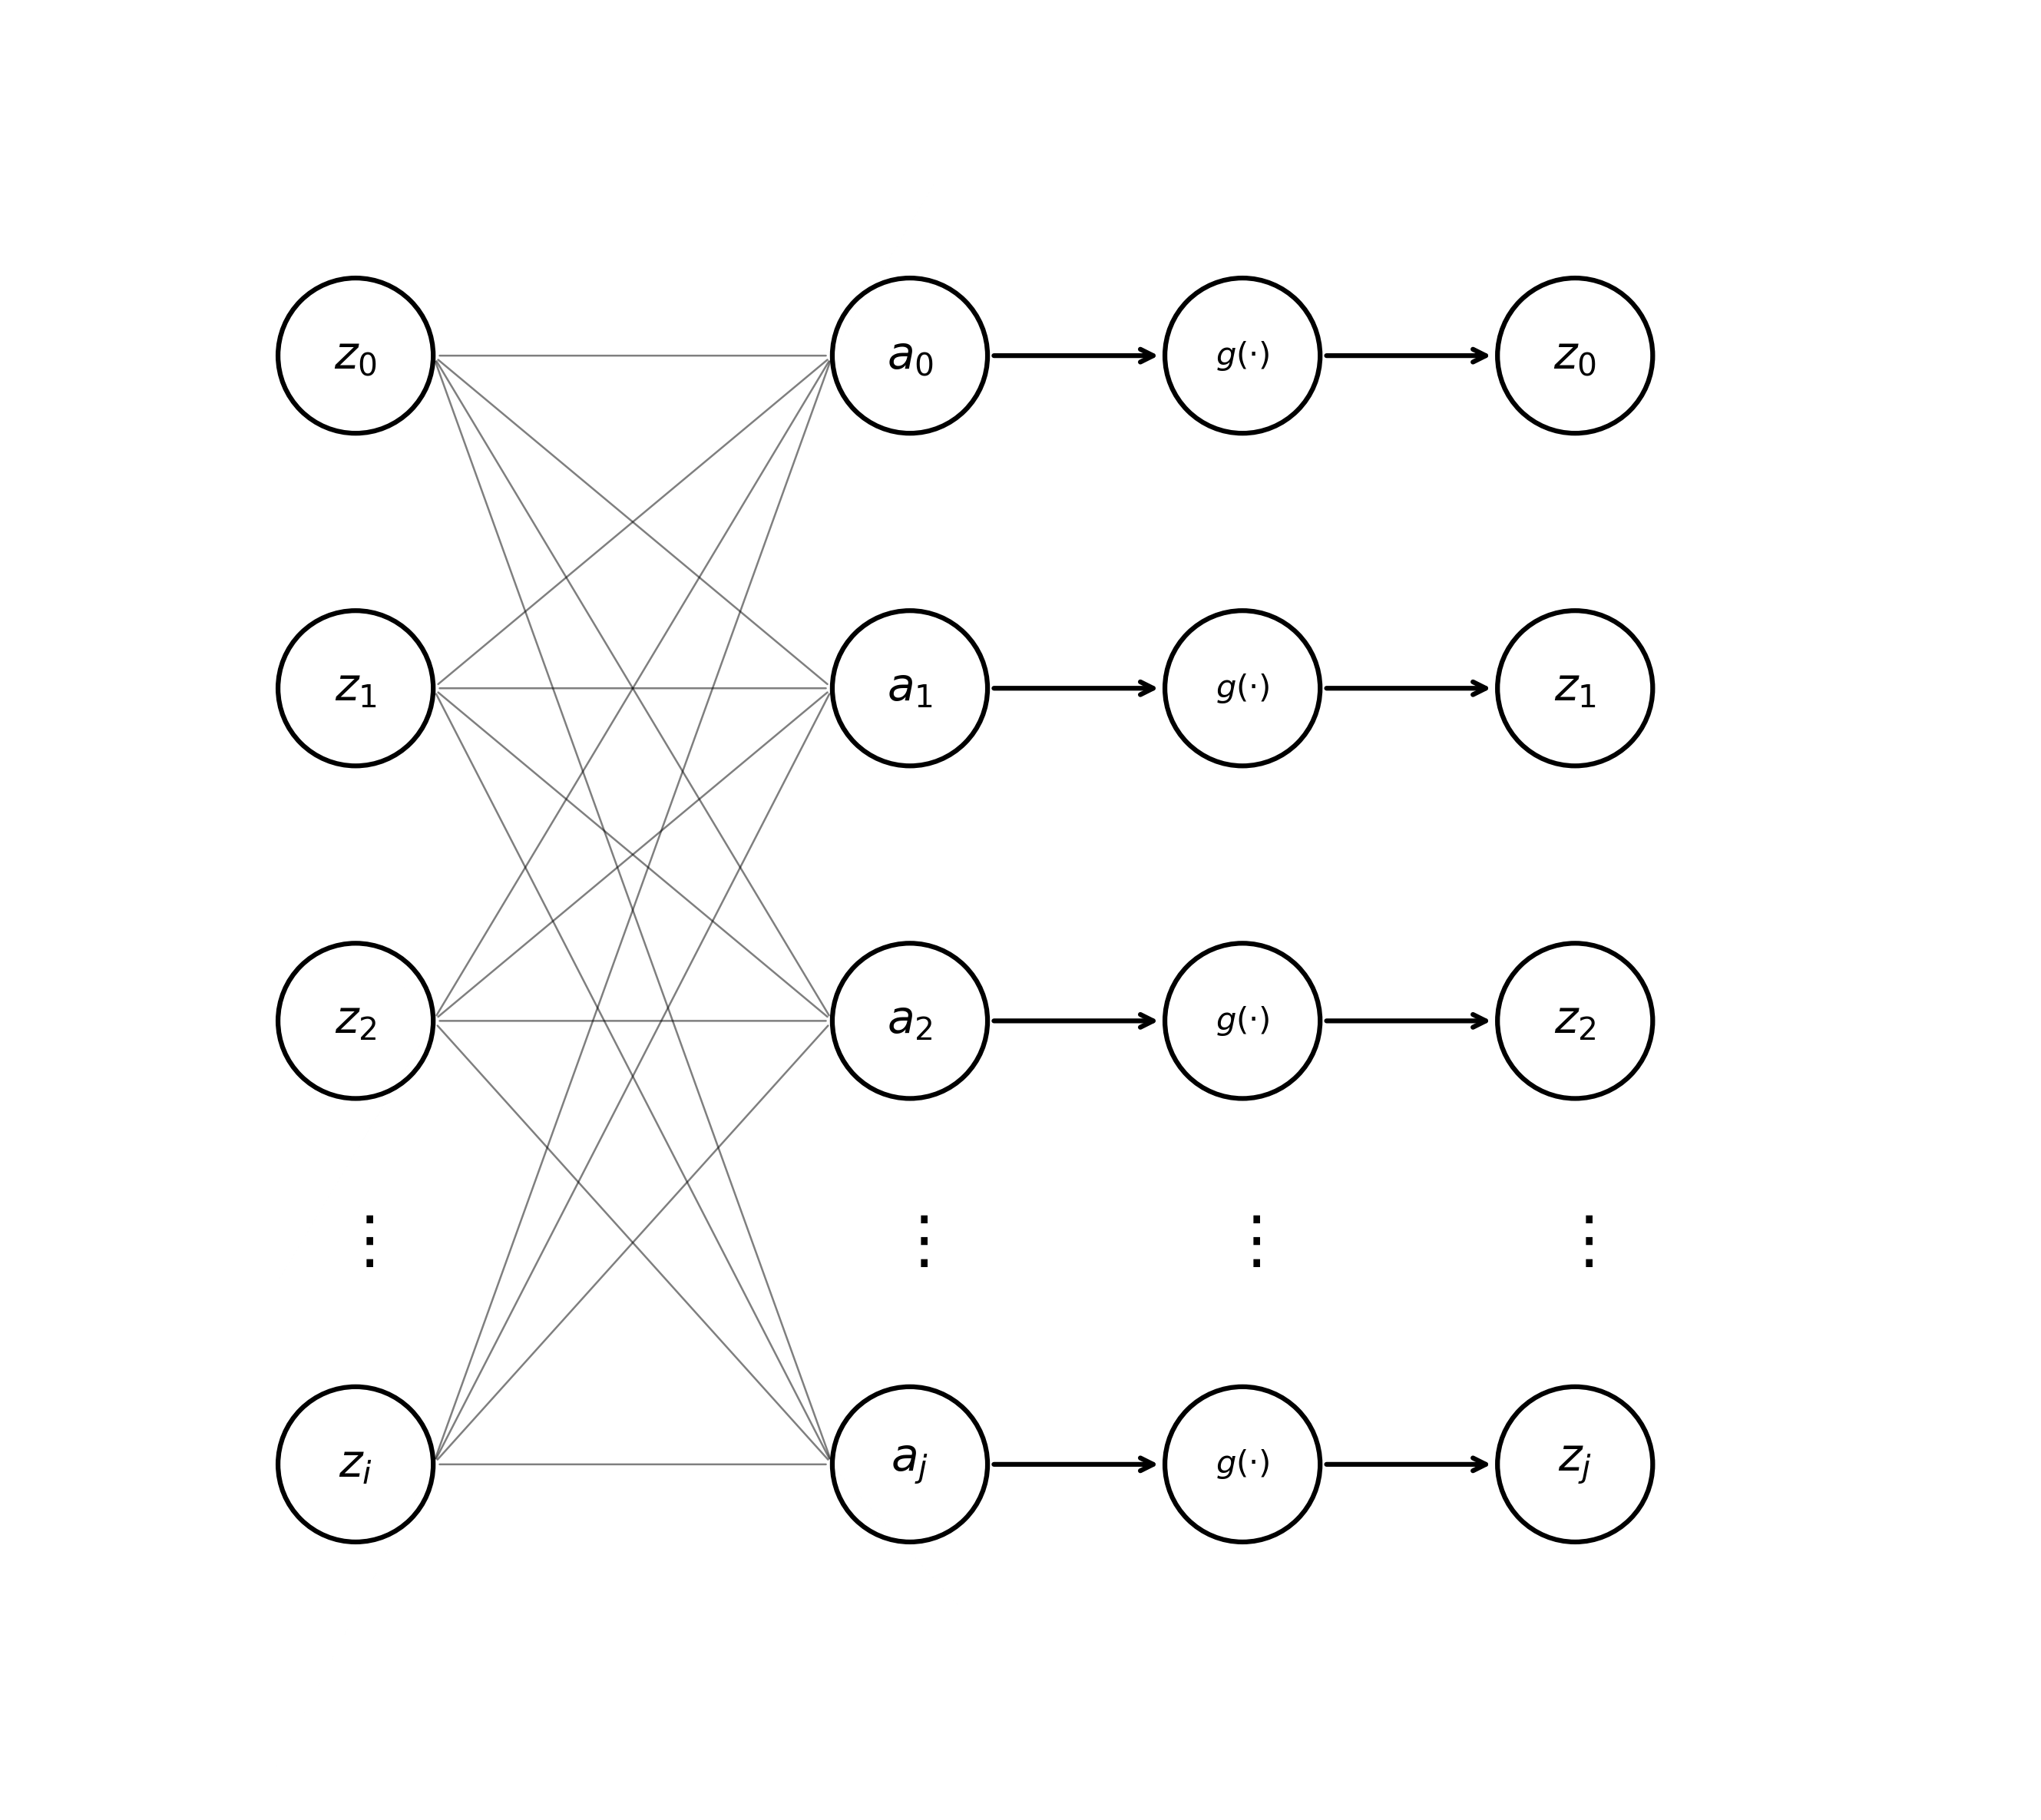

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
ax.set_xlim(-1, 8)
ax.set_ylim(-1, 7)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35  # node radius

# --- Positions ---
input_x = 0.5
a_x = 3.0
tanh_x = 4.5
z_x = 6.0

input_ys = [5.5, 4.0, 2.5, 0.5]       # z0, z1, z2, zi
a_ys     = [5.5, 4.0, 2.5, 0.5]       # a0, a1, a2, aj
tanh_ys  = [5.5, 4.0, 2.5, 0.5]       # tanh nodes
z_ys     = [5.5, 4.0, 2.5, 0.5]       # z0, z1, z2, zj

# --- Helper: draw a circle with text ---
def draw_node(x, y, text, fontsize=14):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

# --- Draw input nodes (z_i) ---
input_labels = [r'$z_0$', r'$z_1$', r'$z_2$', r'$z_i$']
for y, label in zip(input_ys, input_labels):
    draw_node(input_x, y, label)
ax.text(input_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw pre-activation (a_j) nodes ---
a_labels = [r'$a_0$', r'$a_1$', r'$a_2$', r'$a_j$']
for y, label in zip(a_ys, a_labels):
    draw_node(a_x, y, label)
ax.text(a_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw tanh nodes ---
for y in tanh_ys:
    draw_node(tanh_x, y, r'$g(\cdot)$', fontsize=10)
ax.text(tanh_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw output (z_j) nodes ---
z_labels = [r'$z_0$', r'$z_1$', r'$z_2$', r'$z_j$']
for y, label in zip(z_ys, z_labels):
    draw_node(z_x, y, label)
ax.text(z_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Connections: input -> a (all-to-all) ---
for iy in input_ys:
    for ay in a_ys:
        ax.annotate('', xy=(a_x - r, ay), xytext=(input_x + r, iy),
                    arrowprops=dict(arrowstyle='-', color='black', lw=0.6, alpha=0.5))

# --- Connections: a -> tanh (one-to-one) ---
for ay, ty in zip(a_ys, tanh_ys):
    ax.annotate('', xy=(tanh_x - r, ty), xytext=(a_x + r, ay),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

# --- Connections: tanh -> Z (one-to-one) ---
for ty, zy in zip(tanh_ys, z_ys):
    ax.annotate('', xy=(z_x - r, zy), xytext=(tanh_x + r, ty),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

plt.tight_layout()
plt.show()

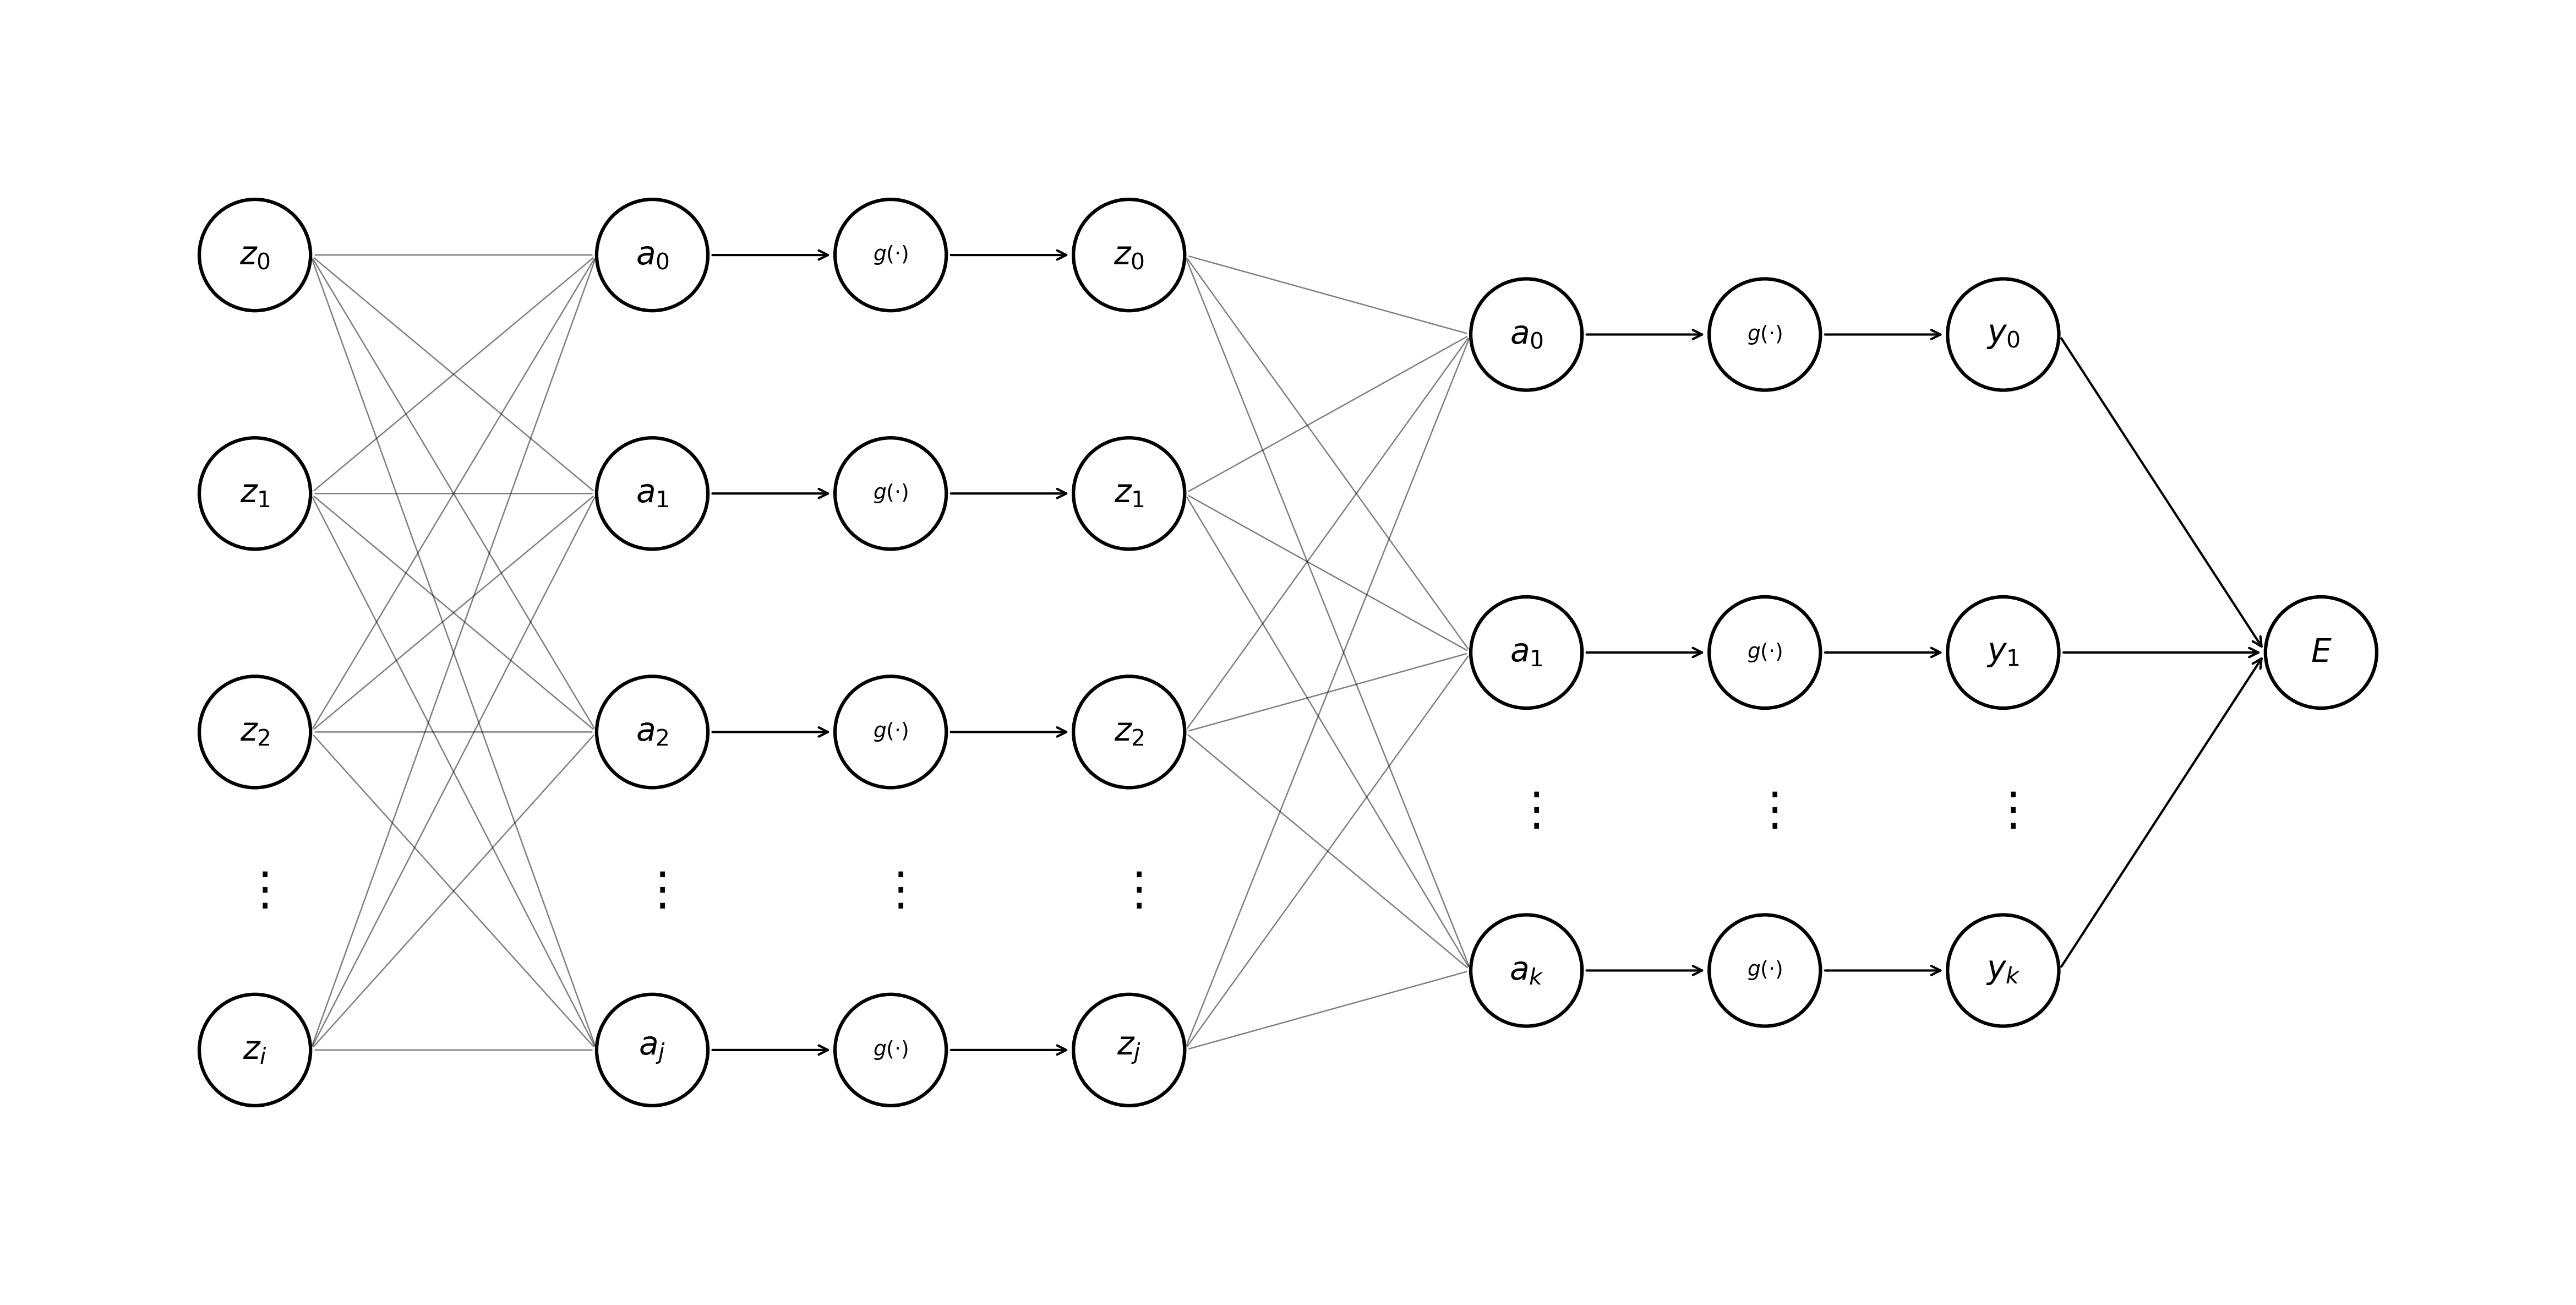

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(16, 8), dpi=300)
ax.set_xlim(-1, 15)
ax.set_ylim(-1, 7)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35  # node radius

# --- Positions ---
input_x = 0.5
a_x = 3.0
tanh_x = 4.5
z_x = 6.0
a2_x = 8.5
tanh2_x = 10.0
y_x = 11.5
e_x = 13.5

input_ys = [5.5, 4.0, 2.5, 0.5]       # z0, z1, z2, zi
a_ys     = [5.5, 4.0, 2.5, 0.5]       # a0, a1, a2, aj
tanh_ys  = [5.5, 4.0, 2.5, 0.5]       # g(.) nodes
z_ys     = [5.5, 4.0, 2.5, 0.5]       # z0, z1, z2, zj
a2_ys    = [5.0, 3.0, 1.0]            # a0, a1, ak
tanh2_ys = [5.0, 3.0, 1.0]            # g(.) nodes
y_ys     = [5.0, 3.0, 1.0]            # y0, y1, yk
e_ys     = [3.0]                       # E

# --- Helper: draw a circle with text ---
def draw_node(x, y, text, fontsize=14):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

# --- Draw input nodes (z_i) ---
input_labels = [r'$z_0$', r'$z_1$', r'$z_2$', r'$z_i$']
for y, label in zip(input_ys, input_labels):
    draw_node(input_x, y, label)
ax.text(input_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw pre-activation (a_j) nodes ---
a_labels = [r'$a_0$', r'$a_1$', r'$a_2$', r'$a_j$']
for y, label in zip(a_ys, a_labels):
    draw_node(a_x, y, label)
ax.text(a_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw g(.) nodes (hidden) ---
for y in tanh_ys:
    draw_node(tanh_x, y, r'$g(\cdot)$', fontsize=9)
ax.text(tanh_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw hidden (z_j) nodes ---
z_labels = [r'$z_0$', r'$z_1$', r'$z_2$', r'$z_j$']
for y, label in zip(z_ys, z_labels):
    draw_node(z_x, y, label)
ax.text(z_x, 1.5, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw output pre-activation (a_k) nodes ---
a2_labels = [r'$a_0$', r'$a_1$', r'$a_k$']
for y, label in zip(a2_ys, a2_labels):
    draw_node(a2_x, y, label)
ax.text(a2_x, 2.0, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw output g(.) nodes ---
for y in tanh2_ys:
    draw_node(tanh2_x, y, r'$g(\cdot)$', fontsize=9)
ax.text(tanh2_x, 2.0, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw output (y_k) nodes ---
y_labels = [r'$y_0$', r'$y_1$', r'$y_k$']
for y, label in zip(y_ys, y_labels):
    draw_node(y_x, y, label)
ax.text(y_x, 2.0, r'$\vdots$', ha='center', va='center', fontsize=20)

# --- Draw error node ---
draw_node(e_x, e_ys[0], r'$E$', fontsize=14)

# --- Connections: input -> a (all-to-all) ---
for iy in input_ys:
    for ay in a_ys:
        ax.annotate('', xy=(a_x - r, ay), xytext=(input_x + r, iy),
                    arrowprops=dict(arrowstyle='-', color='black', lw=0.6, alpha=0.5))

# --- Connections: a -> g(.) (one-to-one) ---
for ay, ty in zip(a_ys, tanh_ys):
    ax.annotate('', xy=(tanh_x - r, ty), xytext=(a_x + r, ay),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.0))

# --- Connections: g(.) -> z (one-to-one) ---
for ty, zy in zip(tanh_ys, z_ys):
    ax.annotate('', xy=(z_x - r, zy), xytext=(tanh_x + r, ty),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.0))

# --- Connections: z -> a2 (all-to-all) ---
for zy in z_ys:
    for ay in a2_ys:
        ax.annotate('', xy=(a2_x - r, ay), xytext=(z_x + r, zy),
                    arrowprops=dict(arrowstyle='-', color='black', lw=0.6, alpha=0.5))

# --- Connections: a2 -> g(.) (one-to-one) ---
for ay, ty in zip(a2_ys, tanh2_ys):
    ax.annotate('', xy=(tanh2_x - r, ty), xytext=(a2_x + r, ay),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.0))

# --- Connections: g(.) -> y (one-to-one) ---
for ty, yy in zip(tanh2_ys, y_ys):
    ax.annotate('', xy=(y_x - r, yy), xytext=(tanh2_x + r, ty),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.0))

# --- Connections: y -> E (all-to-one) ---
for yy in y_ys:
    ax.annotate('', xy=(e_x - r, e_ys[0]), xytext=(y_x + r, yy),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.0))

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import Image, display

# ── Forward-pass computation ─────────────────────────────
np.random.seed(42)
z_in = np.array([0.50, -0.30, 0.80, 0.10])
W1 = np.array([[ 0.50, -0.20,  0.30,  0.10],
                [-0.40,  0.60,  0.10, -0.30],
                [ 0.20,  0.10, -0.50,  0.40],
                [ 0.30, -0.10,  0.20, -0.20]])
a_hid = W1 @ z_in
z_hid = np.tanh(a_hid)

W2 = np.array([[ 0.40, -0.30,  0.20,  0.10],
                [-0.20,  0.50,  0.30, -0.10],
                [ 0.10,  0.20, -0.40,  0.30]])
a_out = W2 @ z_hid
y_out = np.tanh(a_out)
target = np.array([1.0, 0.0, 0.0])
E_val = 0.5 * np.sum((y_out - target) ** 2)

print("z_in:", z_in)
print("a_hid:", a_hid)
print("z_hid:", z_hid)
print("a_out:", a_out)
print("y_out:", y_out)
print("E:", E_val)

z_in: [ 0.5 -0.3  0.8  0.1]
a_hid: [ 0.56 -0.33 -0.29  0.32]
z_hid: [ 0.50797743 -0.31852078 -0.28213481  0.30950692]
a_out: [ 0.27327094 -0.37644701  0.19279959]
y_out: [ 0.26666581 -0.35961793  0.19044569]
E: 0.3516868213857772


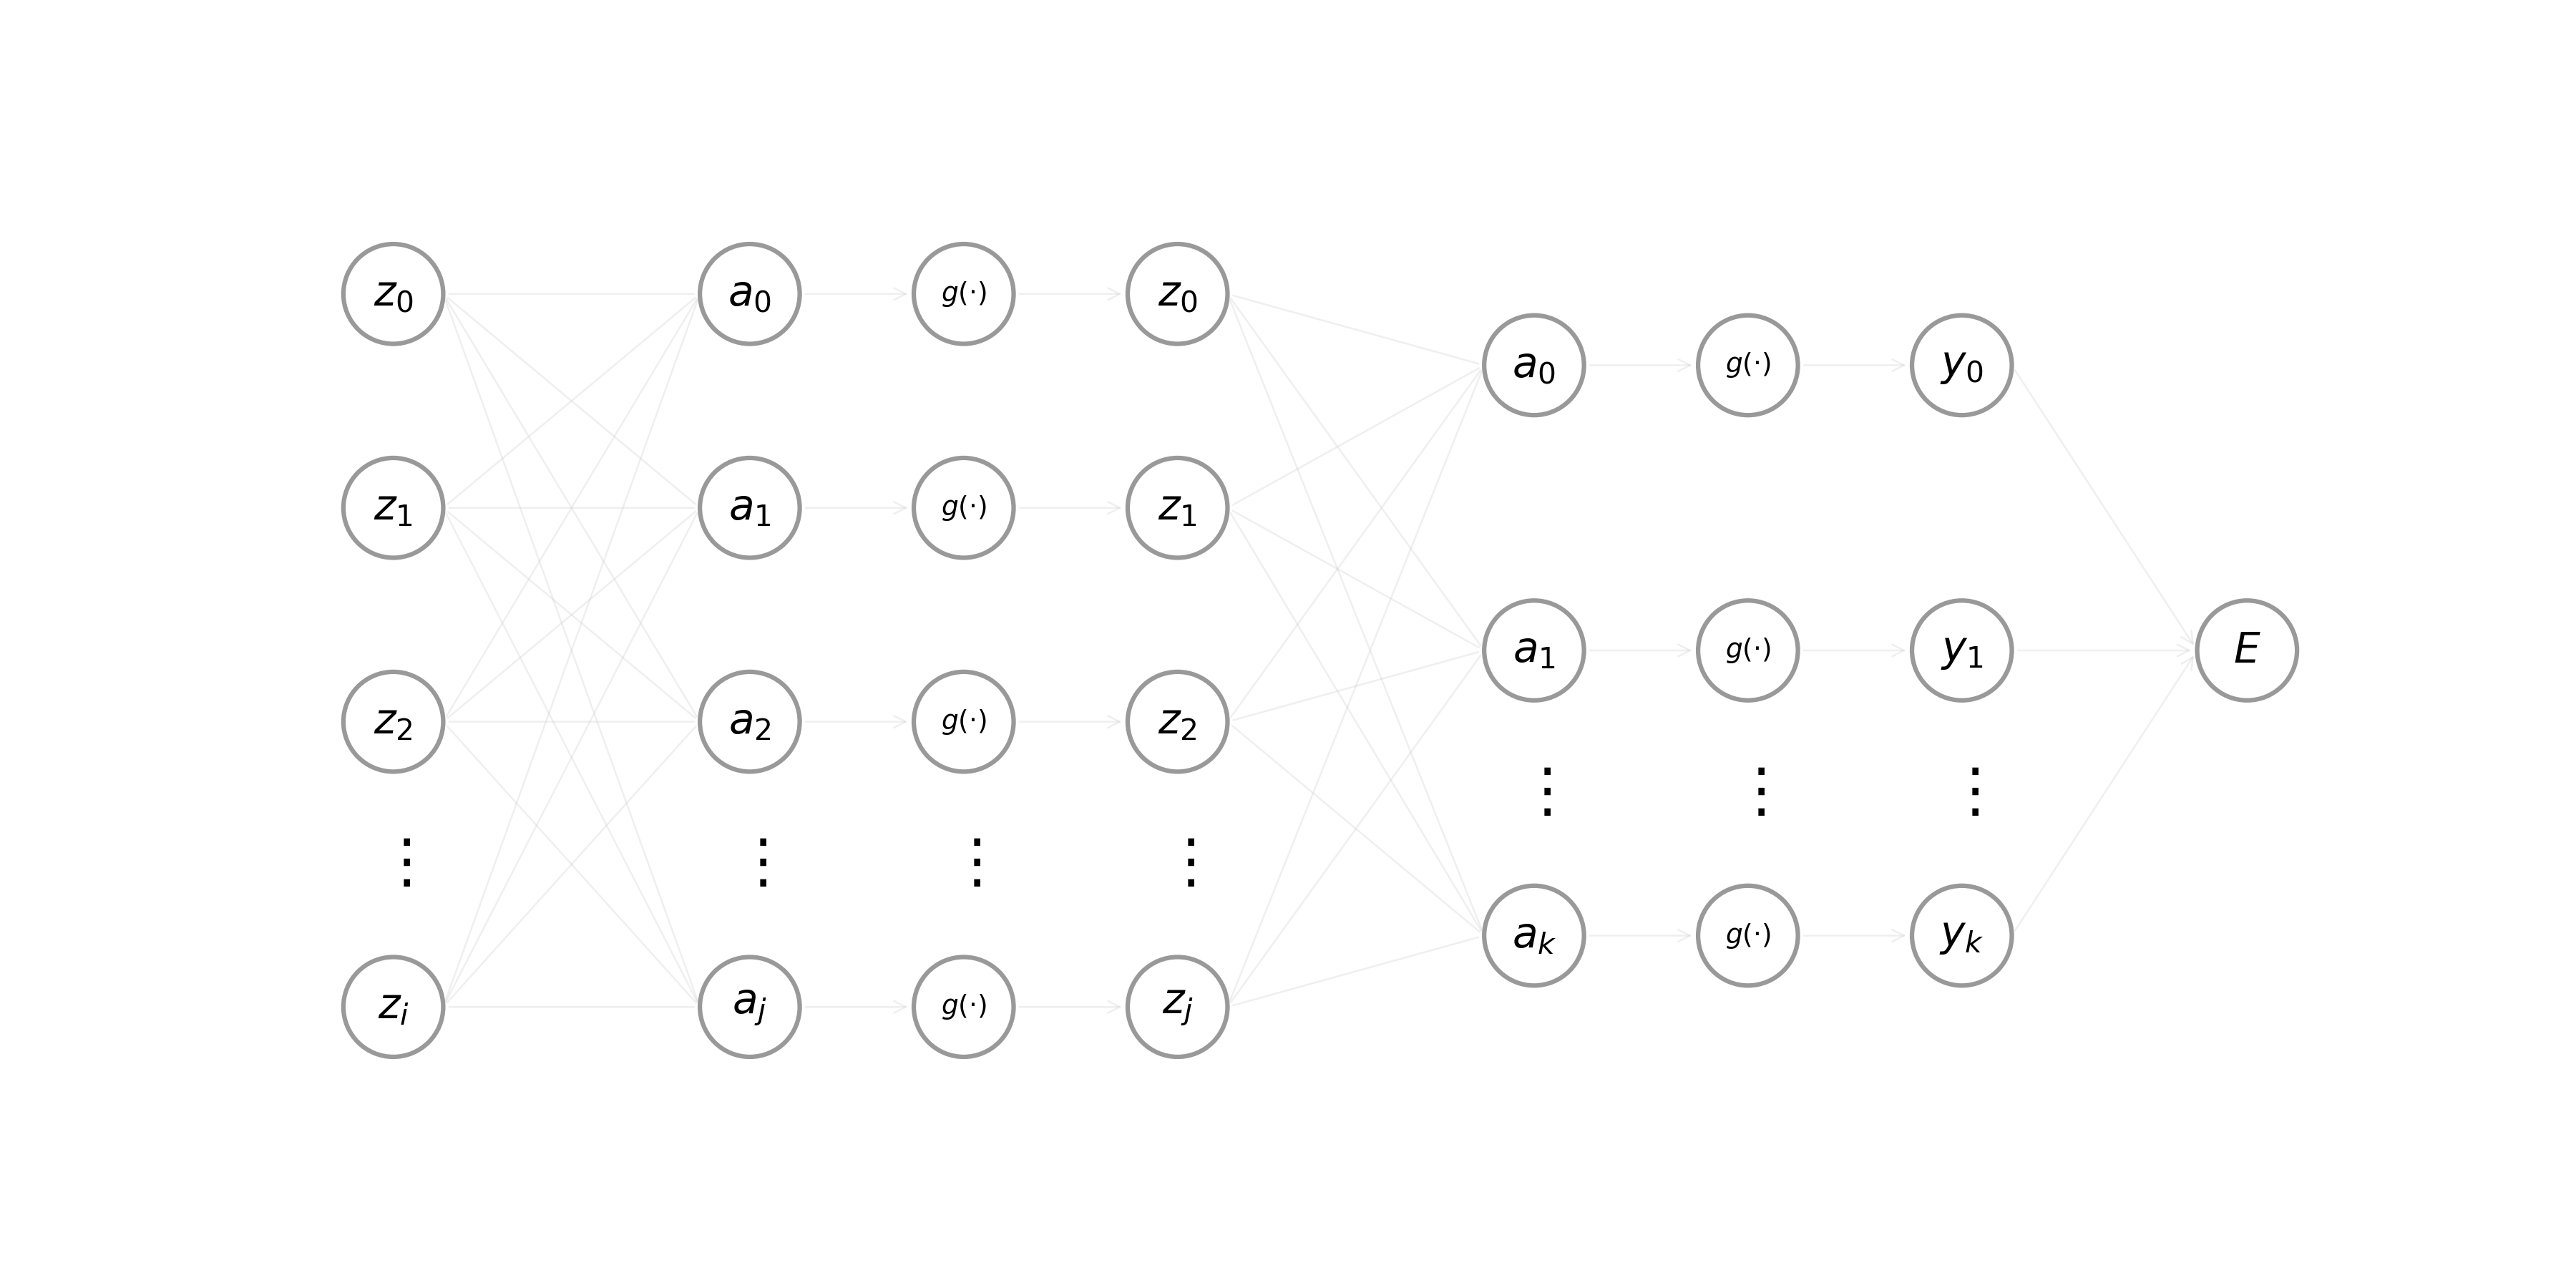

GIF saved to: assets/img/ml-concepts/backprop/forward_pass.gif


In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import Image, display

# ── Forward-pass computation ─────────────────────────────
np.random.seed(42)
z_in = np.array([0.50, -0.30, 0.80, 0.10])
W1 = np.array([[ 0.50, -0.20,  0.30,  0.10],
                [-0.40,  0.60,  0.10, -0.30],
                [ 0.20,  0.10, -0.50,  0.40],
                [ 0.30, -0.10,  0.20, -0.20]])
a_hid = W1 @ z_in
z_hid = np.tanh(a_hid)

W2 = np.array([[ 0.40, -0.30,  0.20,  0.10],
                [-0.20,  0.50,  0.30, -0.10],
                [ 0.10,  0.20, -0.40,  0.30]])
a_out = W2 @ z_hid
y_out = np.tanh(a_out)
target = np.array([1.0, 0.0, 0.0])
E_val = 0.5 * np.sum((y_out - target) ** 2)

# ── Layout ───────────────────────────────────────────────
r = 0.35

col_x = {
    'input': 0.5, 'a1': 3.0, 'g1': 4.5, 'z': 6.0,
    'a2': 8.5, 'g2': 10.0, 'y': 11.5, 'E': 13.5,
}
col_ys = {
    'input': [5.5, 4.0, 2.5, 0.5],
    'a1':    [5.5, 4.0, 2.5, 0.5],
    'g1':    [5.5, 4.0, 2.5, 0.5],
    'z':     [5.5, 4.0, 2.5, 0.5],
    'a2':    [5.0, 3.0, 1.0],
    'g2':    [5.0, 3.0, 1.0],
    'y':     [5.0, 3.0, 1.0],
    'E':     [3.0],
}
col_labels = {
    'input': [r'$z_0$', r'$z_1$', r'$z_2$', r'$z_i$'],
    'a1':    [r'$a_0$', r'$a_1$', r'$a_2$', r'$a_j$'],
    'g1':    [r'$g(\cdot)$'] * 4,
    'z':     [r'$z_0$', r'$z_1$', r'$z_2$', r'$z_j$'],
    'a2':    [r'$a_0$', r'$a_1$', r'$a_k$'],
    'g2':    [r'$g(\cdot)$'] * 3,
    'y':     [r'$y_0$', r'$y_1$', r'$y_k$'],
    'E':     [r'$E$'],
}
col_values = {
    'input': z_in, 'a1': a_hid, 'g1': None, 'z': z_hid,
    'a2': a_out, 'g2': None, 'y': y_out, 'E': np.array([E_val]),
}
col_fs = {
    'input': 14, 'a1': 14, 'g1': 9, 'z': 14,
    'a2': 14, 'g2': 9, 'y': 14, 'E': 14,
}
vdots_pos = {
    'input': (0.5, 1.5), 'a1': (3.0, 1.5), 'g1': (4.5, 1.5),
    'z': (6.0, 1.5), 'a2': (8.5, 2.0), 'g2': (10.0, 2.0),
    'y': (11.5, 2.0),
}

# Edge groups: (source_col, target_col, connection_type, arrowstyle)
edges = {
    'in_a1':  ('input', 'a1', 'all',     '-'),
    'a1_g1':  ('a1',    'g1', 'one',     '->'),
    'g1_z':   ('g1',    'z',  'one',     '->'),
    'z_a2':   ('z',     'a2', 'all',     '-'),
    'a2_g2':  ('a2',    'g2', 'one',     '->'),
    'g2_y':   ('g2',    'y',  'one',     '->'),
    'y_E':    ('y',     'E',  'all_one', '->'),
}

# ── Animation stages ─────────────────────────────────────
stages = [
    (set(),                                         None,  set(),         ''),
    ({'input'},                                     'input', set(),       r'Input activations $z_i$'),
    ({'input'},                                     'a1',  {'in_a1'},     r'Pre-activations $a_j = \sum_i w_{ji}\, z_i$'),
    ({'input', 'a1'},                               'g1',  {'a1_g1'},     r'Activation function $g(\cdot)$'),
    ({'input', 'a1', 'g1'},                         'z',   {'g1_z'},      r'Hidden activations $z_j = g(a_j)$'),
    ({'input', 'a1', 'g1', 'z'},                    'a2',  {'z_a2'},      r'Pre-activations $a_k = \sum_j w_{kj}\, z_j$'),
    ({'input', 'a1', 'g1', 'z', 'a2'},              'g2',  {'a2_g2'},     r'Activation function $g(\cdot)$'),
    ({'input', 'a1', 'g1', 'z', 'a2', 'g2'},        'y',   {'g2_y'},      r'Output $y_k = g(a_k)$'),
    ({'input', 'a1', 'g1', 'z', 'a2', 'g2', 'y'},   'E',   {'y_E'},       r'Error $E = \frac{1}{K}\sum_{k=1}^{K}(y_k - t_k)^2$'),
    ({'input', 'a1', 'g1', 'z', 'a2', 'g2', 'y', 'E'}, None, set(),      'Forward pass complete'),
]

# Colors
C_INACTIVE  = '#FFFFFF'
C_ACTIVE    = '#FFB74D'
C_DONE      = '#81C784'
C_EDGE_OFF  = '#CCCCCC'
C_EDGE_ON   = '#FF7043'
C_VALUE     = '#1565C0'

# ── Drawing ──────────────────────────────────────────────
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)

def draw_frame(frame_idx):
    ax.clear()
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 6)
    ax.set_aspect('equal')
    ax.axis('off')

    completed, active, active_edges, desc = stages[min(frame_idx, len(stages) - 1)]

    # Stage label
    ax.text(7.0, 6.7, desc, ha='center', va='center', fontsize=14, fontstyle='italic')

    # Draw edges
    for ename, (src, tgt, conn, astyle) in edges.items():
        sx, tx = col_x[src], col_x[tgt]
        sys_, tys = col_ys[src], col_ys[tgt]

        is_active = ename in active_edges
        both_done = src in completed and tgt in completed
        color = C_EDGE_ON if is_active else ('#AAAAAA' if both_done else C_EDGE_OFF)
        alpha = 0.8 if is_active else (0.45 if both_done else 0.3)
        lw = 1.5 if is_active else 0.6

        pairs = []
        if conn == 'all':
            pairs = [(sy, ty) for sy in sys_ for ty in tys]
        elif conn == 'one':
            pairs = list(zip(sys_, tys))
        elif conn == 'all_one':
            pairs = [(sy, tys[0]) for sy in sys_]

        for sy, ty in pairs:
            ax.annotate('', xy=(tx - r, ty), xytext=(sx + r, sy),
                        arrowprops=dict(arrowstyle=astyle, color=color, lw=lw, alpha=alpha))

    # Draw nodes
    for cname in col_x:
        x = col_x[cname]
        ys = col_ys[cname]
        labels = col_labels[cname]
        values = col_values[cname]
        fs = col_fs[cname]

        if cname in completed:
            fc, ec = C_DONE, '#388E3C'
        elif cname == active:
            fc, ec = C_ACTIVE, '#E65100'
        else:
            fc, ec = C_INACTIVE, '#999999'

        for i, (y, label) in enumerate(zip(ys, labels)):
            circ = plt.Circle((x, y), r, facecolor=fc, edgecolor=ec, linewidth=1.5, zorder=3)
            ax.add_patch(circ)
            ax.text(x, y, label, ha='center', va='center', fontsize=fs, zorder=4)

            # Numerical value below node
            if values is not None and (cname in completed or cname == active):
                ax.text(x, y - r - 0.18, f'{values[i]:.2f}', ha='center', va='top',
                        fontsize=8, color=C_VALUE, fontweight='bold', zorder=4,
                        bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.7, linewidth=0))

    # Vertical dots
    for cname, (vx, vy) in vdots_pos.items():
        ax.text(vx, vy, r'$\vdots$', ha='center', va='center', fontsize=20)

# Duplicate frames to slow the animation
frame_seq = []
for i in range(len(stages)):
    hold = 4 if i == len(stages) - 1 else 2
    frame_seq.extend([i] * hold)

anim = animation.FuncAnimation(fig, lambda f: draw_frame(frame_seq[f]),
                                frames=len(frame_seq), repeat=True)
gif_path = 'assets/img/ml-concepts/backprop/forward_pass.gif'
anim.save(gif_path, writer='pillow', fps=0.5)
plt.close()

display(Image(filename=gif_path))
print("GIF saved to:", gif_path)

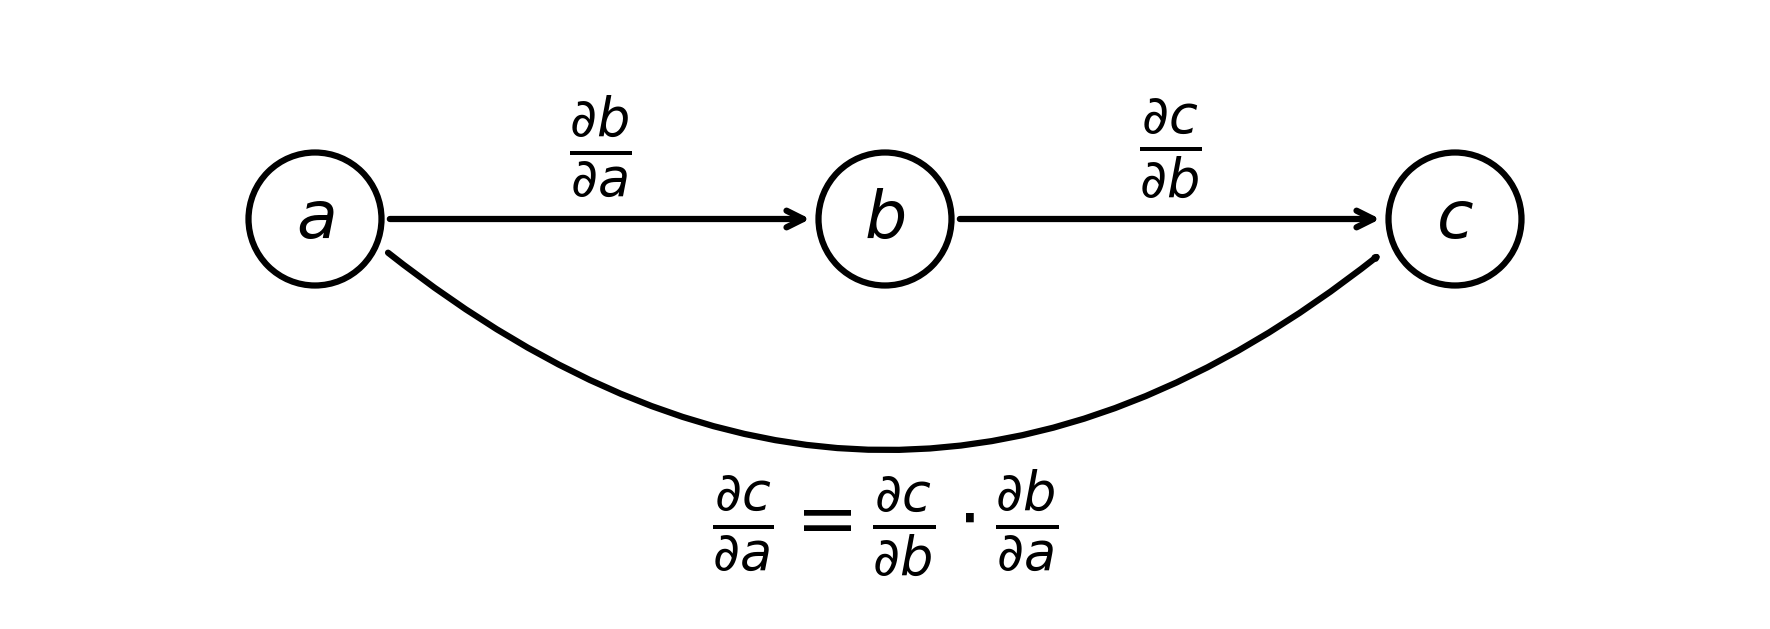

In [68]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), dpi=300)
ax.set_xlim(-1, 8)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35  # node radius

# --- Node positions (horizontal line) ---
ax_pos = (0.5, 0.5)
bx_pos = (3.5, 0.5)
cx_pos = (6.5, 0.5)

# --- Helper: draw a circle with text ---
def draw_node(x, y, text, fontsize=16):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

# --- Draw nodes ---
draw_node(*ax_pos, r'$a$')
draw_node(*bx_pos, r'$b$')
draw_node(*cx_pos, r'$c$')

# --- Straight arrows: a -> b and b -> c ---
ax.annotate('', xy=(bx_pos[0] - r, bx_pos[1]), xytext=(ax_pos[0] + r, ax_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax.annotate('', xy=(cx_pos[0] - r, cx_pos[1]), xytext=(bx_pos[0] + r, bx_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

# --- Labels on straight arrows ---
ax.text(2.0, 0.6, r'$\frac{\partial b}{\partial a}$',
        ha='center', va='bottom', fontsize=18)
ax.text(5.0, 0.6, r'$\frac{\partial c}{\partial b}$',
        ha='center', va='bottom', fontsize=18)

# --- Curved arrow: a -> c (underneath) ---
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches

arc = FancyArrowPatch(
    (ax_pos[0] + r, ax_pos[1] - 0.15),
    (cx_pos[0] - r, cx_pos[1] - 0.15),
    connectionstyle="arc3,rad=0.4",
    arrowstyle='->', color='#000000', lw=1.5, zorder=2
)
ax.add_patch(arc)

# --- Label on curved arrow ---
ax.text(3.5, -1.1, r'$\frac{\partial c}{\partial a} = \frac{\partial c}{\partial b} \cdot \frac{\partial b}{\partial a}$',
        ha='center', va='center', fontsize=18, color='#000000')

plt.tight_layout()
plt.savefig("assets/img/ml-concepts/backprop/backwards_inuit", dpi=300)
plt.show()

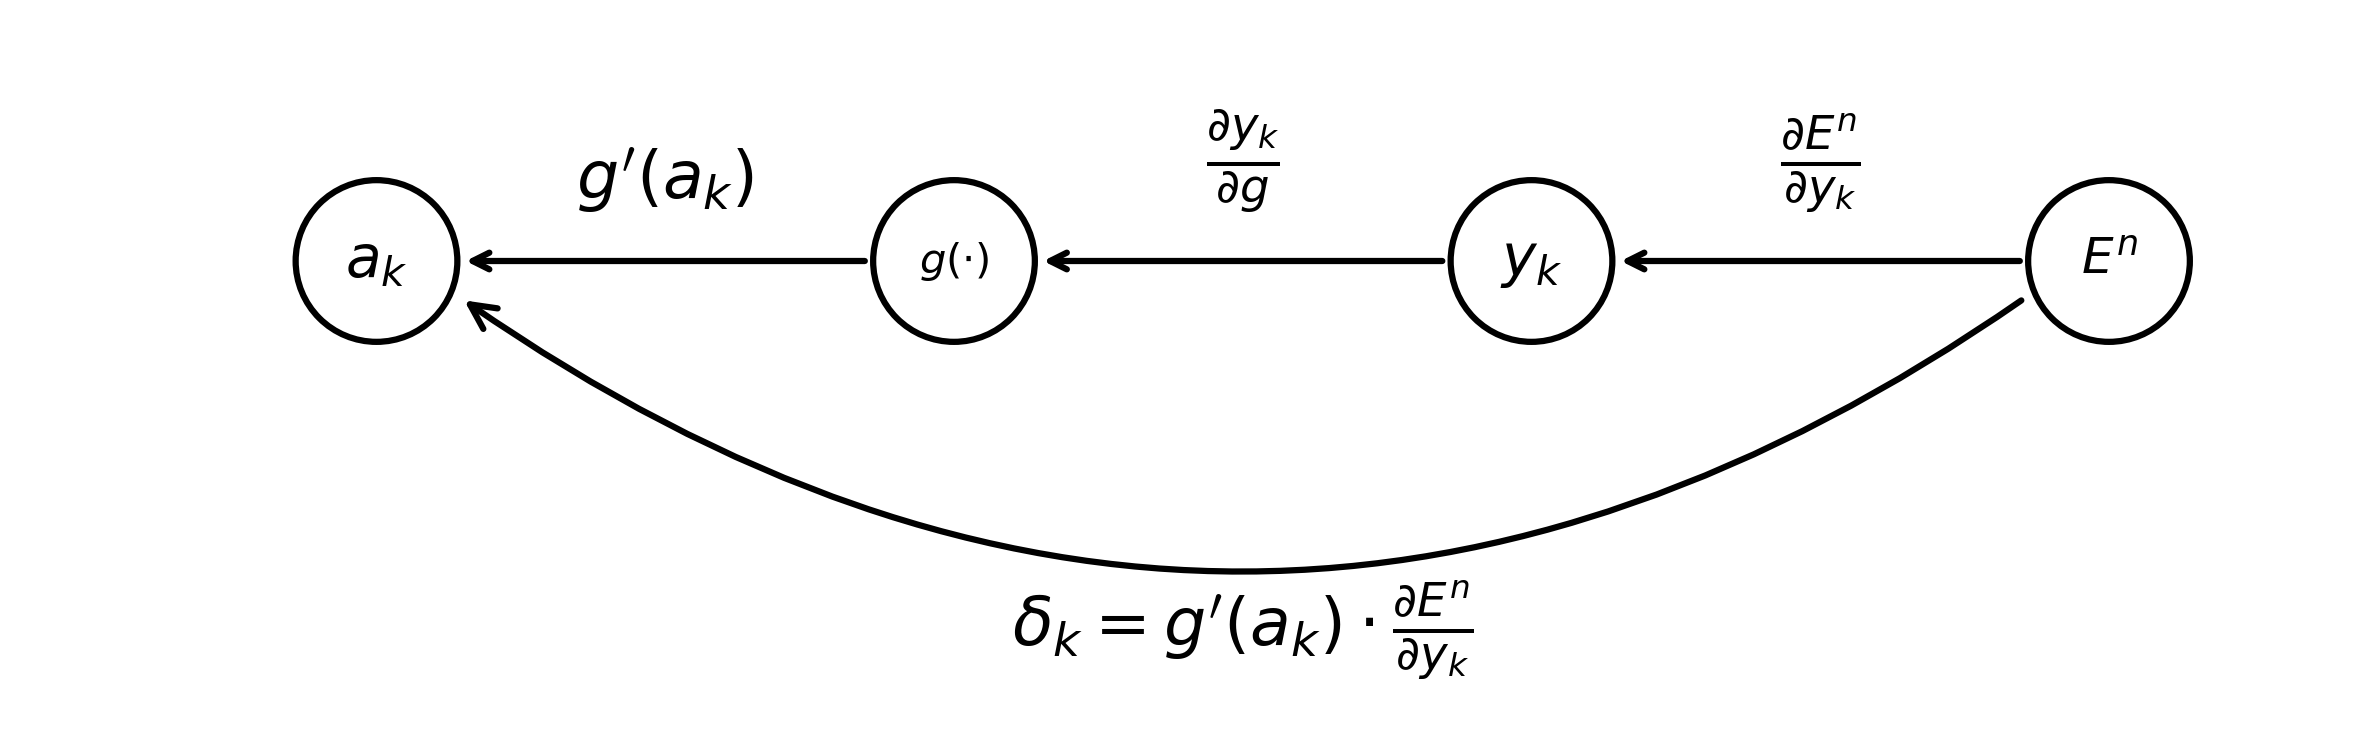

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(1, 1, figsize=(8, 3.5), dpi=300)
ax.set_xlim(-1, 9)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35  # node radius

# --- Node positions (horizontal line) ---
ak_pos = (0.5, 0.5)
gk_pos = (3.0, 0.5)
yk_pos = (5.5, 0.5)
en_pos = (8.0, 0.5)

# --- Helper: draw a circle with text ---
def draw_node(x, y, text, fontsize=16):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

# --- Draw nodes ---
draw_node(*ak_pos, r'$a_k$', fontsize=14)
draw_node(*gk_pos, r'$g(\cdot)$', fontsize=10)
draw_node(*yk_pos, r'$y_k$', fontsize=14)
draw_node(*en_pos, r'$E^n$', fontsize=12)

# --- Straight arrows: E^n -> y_k -> g -> a_k (gradient flow, right to left) ---
ax.annotate('', xy=(yk_pos[0] + r, yk_pos[1]), xytext=(en_pos[0] - r, en_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax.annotate('', xy=(gk_pos[0] + r, gk_pos[1]), xytext=(yk_pos[0] - r, yk_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax.annotate('', xy=(ak_pos[0] + r, ak_pos[1]), xytext=(gk_pos[0] - r, gk_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

# --- Labels on straight arrows ---
ax.text(6.75, 0.7, r'$\frac{\partial E^n}{\partial y_k}$',
        ha='center', va='bottom', fontsize=16)
ax.text(4.25, 0.7, r'$\frac{\partial y_k}{\partial g}$',
        ha='center', va='bottom', fontsize=16)
ax.text(1.75, 0.7, r'$g^\prime(a_k)$',
        ha='center', va='bottom', fontsize=16)

# --- Curved arrow: E^n -> a_k (underneath) ---
arc = FancyArrowPatch(
    (en_pos[0] - r, en_pos[1] - 0.15),
    (ak_pos[0] + r, ak_pos[1] - 0.15),
    connectionstyle="arc3,rad=-0.35",
    arrowstyle='->', color='black', lw=1.5, zorder=2,
    mutation_scale=15
)
ax.add_patch(arc)

# --- Label on curved arrow ---
ax.text(4.25, -1.1, r'$\delta_k = g^\prime(a_k) \cdot \frac{\partial E^n}{\partial y_k}$',
        ha='center', va='center', fontsize=16, color='black')

plt.tight_layout()
plt.savefig("assets/img/ml-concepts/backprop/backwards_inuit", dpi=300)
plt.show()

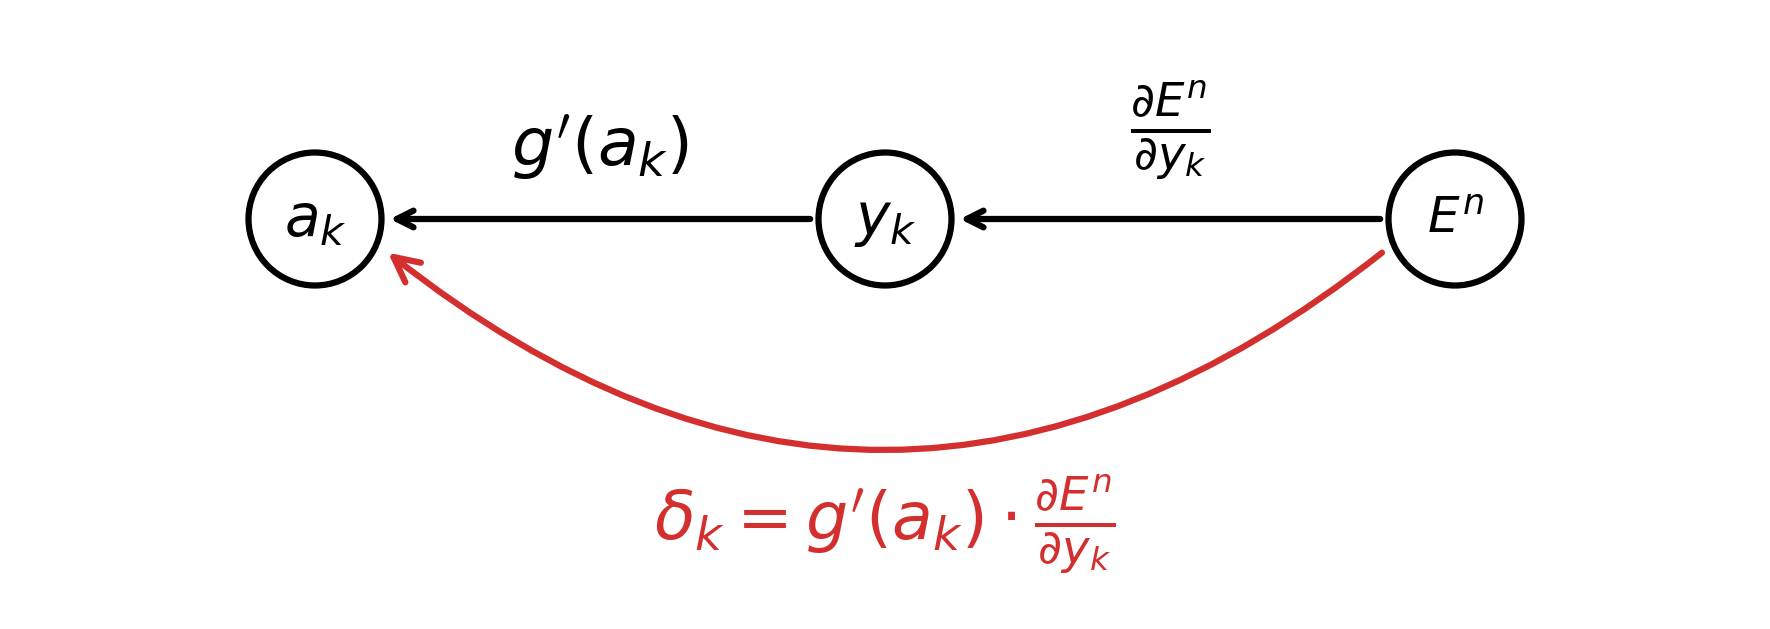

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), dpi=300)
ax.set_xlim(-1, 8)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35  # node radius

# --- Node positions (horizontal line) ---
ak_pos = (0.5, 0.5)
yk_pos = (3.5, 0.5)
en_pos = (6.5, 0.5)

# --- Helper: draw a circle with text ---
def draw_node(x, y, text, fontsize=16):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

# --- Draw nodes ---
draw_node(*ak_pos, r'$a_k$', fontsize=14)
draw_node(*yk_pos, r'$y_k$', fontsize=14)
draw_node(*en_pos, r'$E^n$', fontsize=12)

# --- Straight arrows: E^n -> y_k and y_k -> a_k (gradient flow, right to left) ---
ax.annotate('', xy=(yk_pos[0] + r, yk_pos[1]), xytext=(en_pos[0] - r, en_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax.annotate('', xy=(ak_pos[0] + r, ak_pos[1]), xytext=(yk_pos[0] - r, yk_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

# --- Labels on straight arrows ---
ax.text(5.0, 0.7, r'$\frac{\partial E^n}{\partial y_k}$',
        ha='center', va='bottom', fontsize=16)
ax.text(2.0, 0.7, r'$g^\prime(a_k)$',
        ha='center', va='bottom', fontsize=16)

# --- Curved arrow: E^n -> a_k (underneath) ---
arc = FancyArrowPatch(
    (en_pos[0] - r, en_pos[1] - 0.15),
    (ak_pos[0] + r, ak_pos[1] - 0.15),
    connectionstyle="arc3,rad=-0.4",
    arrowstyle='->', color='#D32F2F', lw=1.5, zorder=2,
    mutation_scale=15
)
ax.add_patch(arc)

# --- Label on curved arrow ---
ax.text(3.5, -1.1, r'$\delta_k = g^\prime(a_k) \cdot \frac{\partial E^n}{\partial y_k}$',
        ha='center', va='center', fontsize=16, color='#D32F2F')

plt.tight_layout()
plt.savefig("assets/img/ml-concepts/backprop/eq_4_proof", dpi=300)
plt.show()

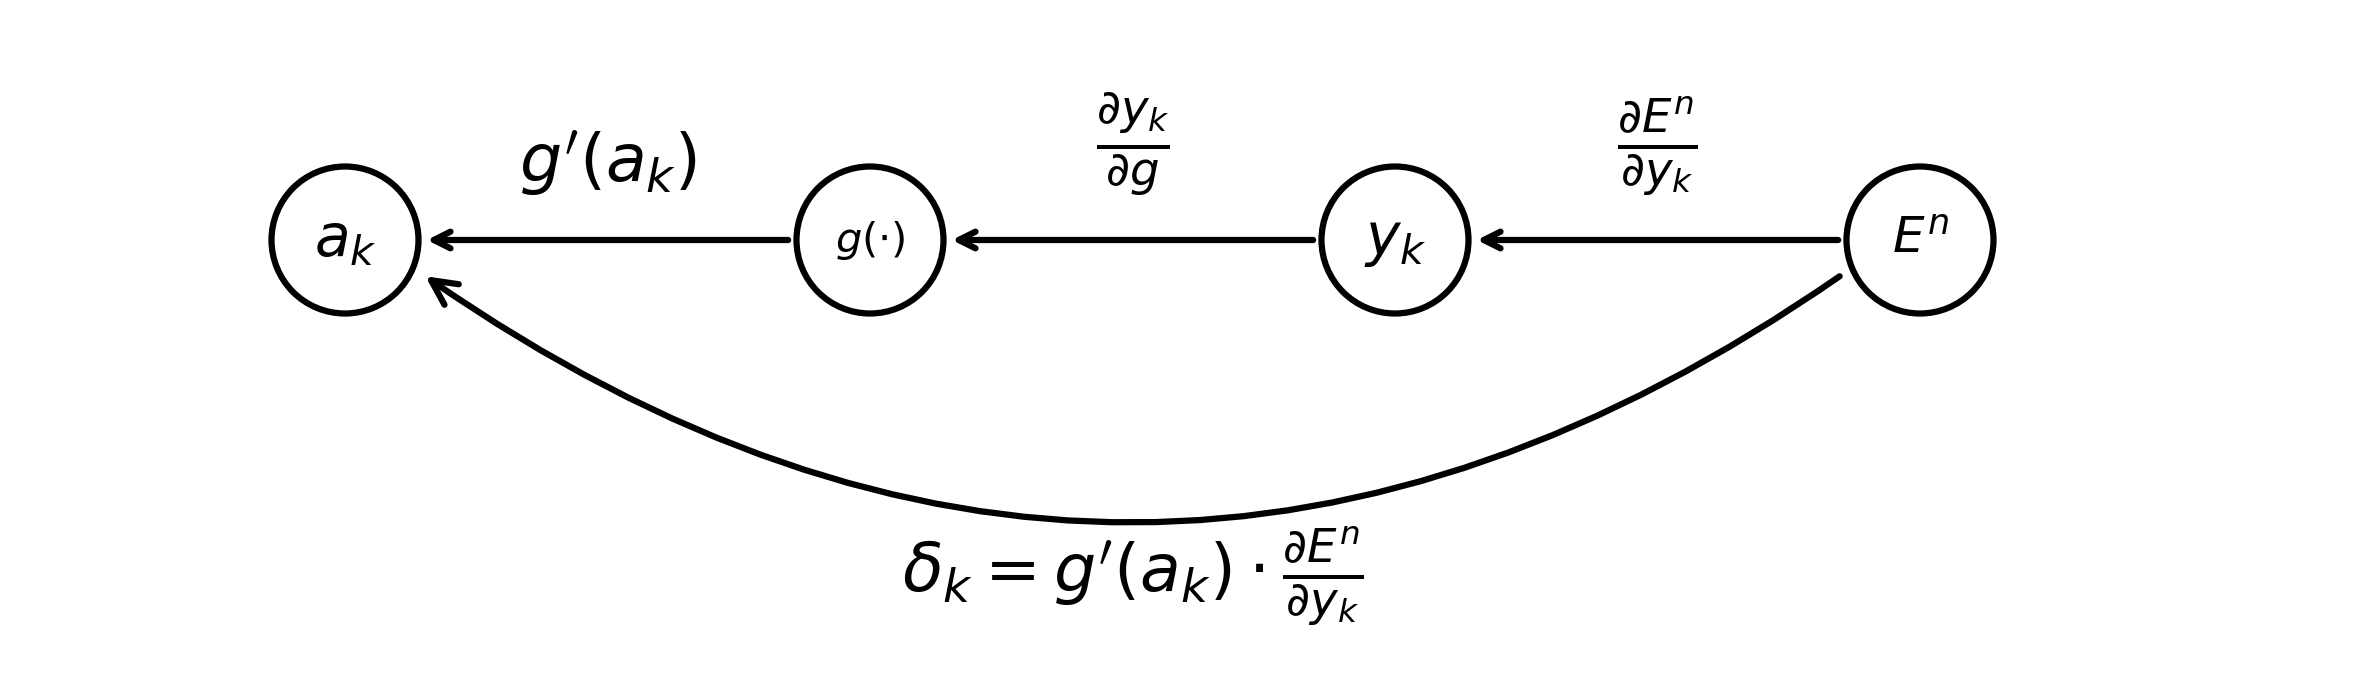

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(1, 1, figsize=(8, 3.5), dpi=300)
ax.set_xlim(-1, 10)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35  # node radius

# --- Node positions (horizontal line) ---
ak_pos = (0.5, 0.5)
gk_pos = (3.0, 0.5)
yk_pos = (5.5, 0.5)
en_pos = (8.0, 0.5)

# --- Helper: draw a circle with text ---
def draw_node(x, y, text, fontsize=16):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

# --- Draw nodes ---
draw_node(*ak_pos, r'$a_k$', fontsize=14)
draw_node(*gk_pos, r'$g(\cdot)$', fontsize=10)
draw_node(*yk_pos, r'$y_k$', fontsize=14)
draw_node(*en_pos, r'$E^n$', fontsize=12)

# --- Straight arrows: E^n -> y_k -> g -> a_k (gradient flow, right to left) ---
ax.annotate('', xy=(yk_pos[0] + r, yk_pos[1]), xytext=(en_pos[0] - r, en_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax.annotate('', xy=(gk_pos[0] + r, gk_pos[1]), xytext=(yk_pos[0] - r, yk_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax.annotate('', xy=(ak_pos[0] + r, ak_pos[1]), xytext=(gk_pos[0] - r, gk_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

# --- Labels on straight arrows ---
ax.text(6.75, 0.7, r'$\frac{\partial E^n}{\partial y_k}$',
        ha='center', va='bottom', fontsize=16)
ax.text(4.25, 0.7, r'$\frac{\partial y_k}{\partial g}$',
        ha='center', va='bottom', fontsize=16)
ax.text(1.75, 0.7, r'$g^\prime(a_k)$',
        ha='center', va='bottom', fontsize=16)

# --- Curved arrow: E^n -> a_k (underneath) ---
arc = FancyArrowPatch(
    (en_pos[0] - r, en_pos[1] - 0.15),
    (ak_pos[0] + r, ak_pos[1] - 0.15),
    connectionstyle="arc3,rad=-0.35",
    arrowstyle='->', color='black', lw=1.5, zorder=2,
    mutation_scale=15
)
ax.add_patch(arc)

# --- Label on curved arrow ---
ax.text(4.25, -1.1, r'$\delta_k = g^\prime(a_k) \cdot \frac{\partial E^n}{\partial y_k}$',
        ha='center', va='center', fontsize=16, color='black')

plt.tight_layout()
plt.savefig("assets/img/ml-concepts/backprop/backwards_inuit", dpi=300)
plt.show()

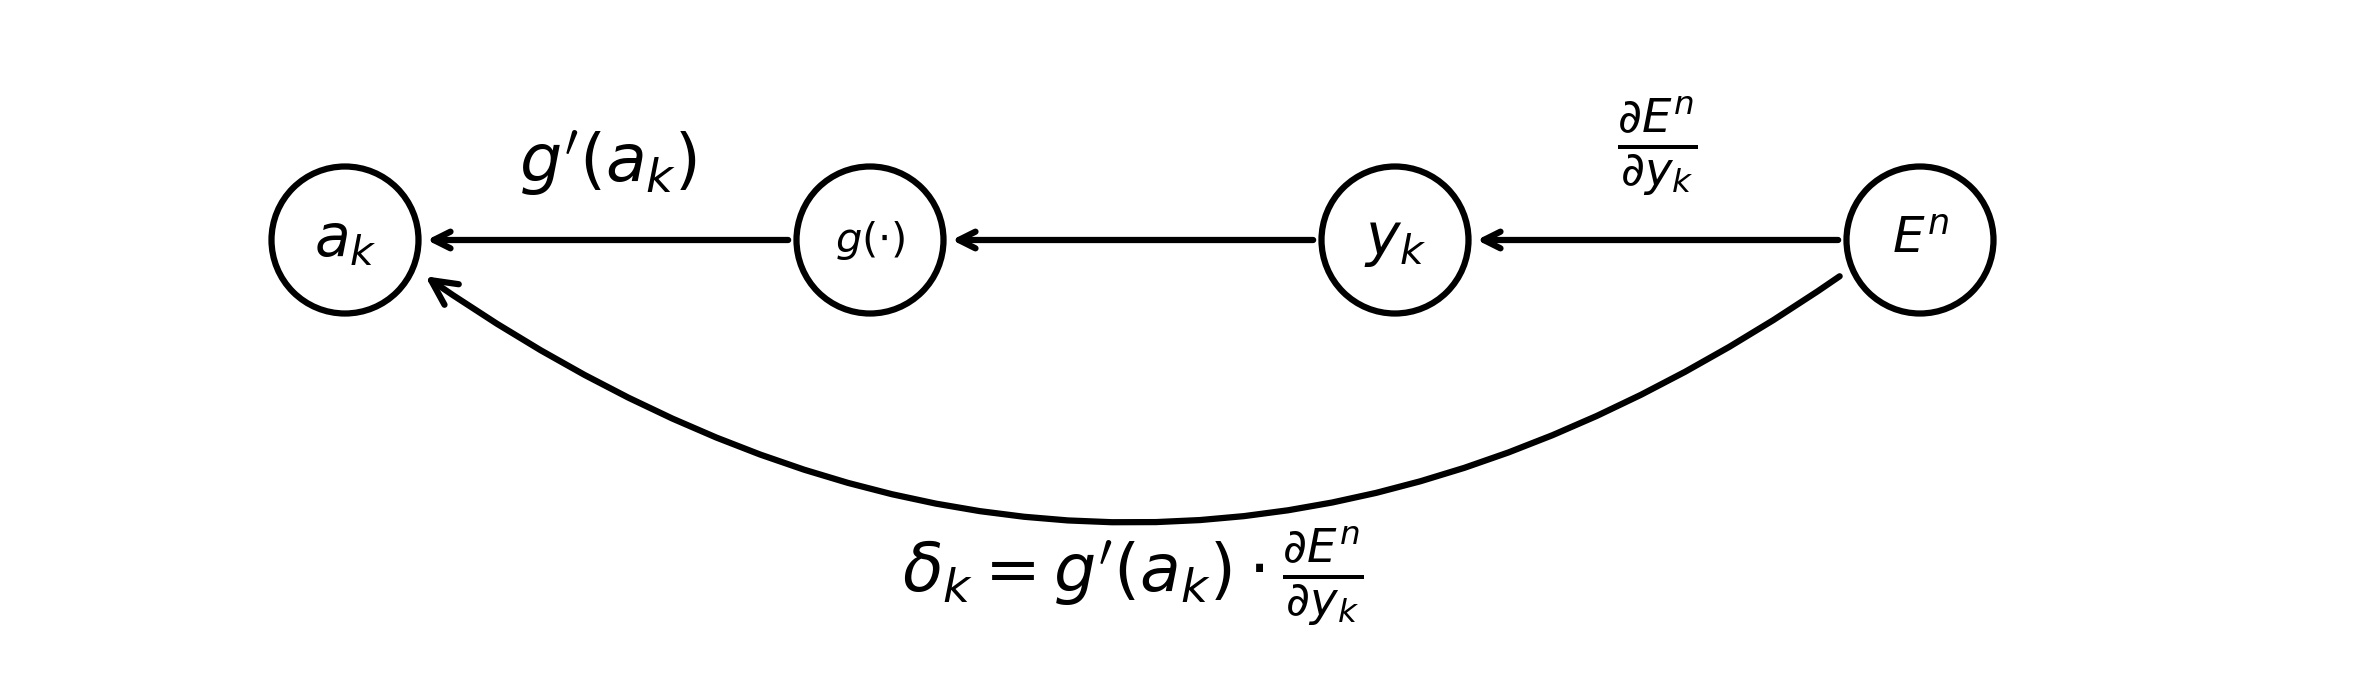

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(1, 1, figsize=(8, 3.5), dpi=300)
ax.set_xlim(-1, 10)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35

ak_pos = (0.5, 0.5)
gk_pos = (3.0, 0.5)
yk_pos = (5.5, 0.5)
en_pos = (8.0, 0.5)

def draw_node(x, y, text, fontsize=16):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

draw_node(*ak_pos, r'$a_k$', fontsize=14)
draw_node(*gk_pos, r'$g(\cdot)$', fontsize=10)
draw_node(*yk_pos, r'$y_k$', fontsize=14)
draw_node(*en_pos, r'$E^n$', fontsize=12)

ax.annotate('', xy=(yk_pos[0] + r, yk_pos[1]), xytext=(en_pos[0] - r, en_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax.annotate('', xy=(gk_pos[0] + r, gk_pos[1]), xytext=(yk_pos[0] - r, yk_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax.annotate('', xy=(ak_pos[0] + r, ak_pos[1]), xytext=(gk_pos[0] - r, gk_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

ax.text(6.75, 0.7, r'$\frac{\partial E^n}{\partial y_k}$',
        ha='center', va='bottom', fontsize=16)
ax.text(1.75, 0.7, r'$g^\prime(a_k)$',
        ha='center', va='bottom', fontsize=16)

arc = FancyArrowPatch(
    (en_pos[0] - r, en_pos[1] - 0.15),
    (ak_pos[0] + r, ak_pos[1] - 0.15),
    connectionstyle="arc3,rad=-0.35",
    arrowstyle='->', color='black', lw=1.5, zorder=2,
    mutation_scale=15
)
ax.add_patch(arc)

ax.text(4.25, -1.1, r'$\delta_k = g^\prime(a_k) \cdot \frac{\partial E^n}{\partial y_k}$',
        ha='center', va='center', fontsize=16, color='black')

plt.tight_layout()
plt.savefig("assets/img/ml-concepts/backprop/backwards_inuit", dpi=300)
plt.show()

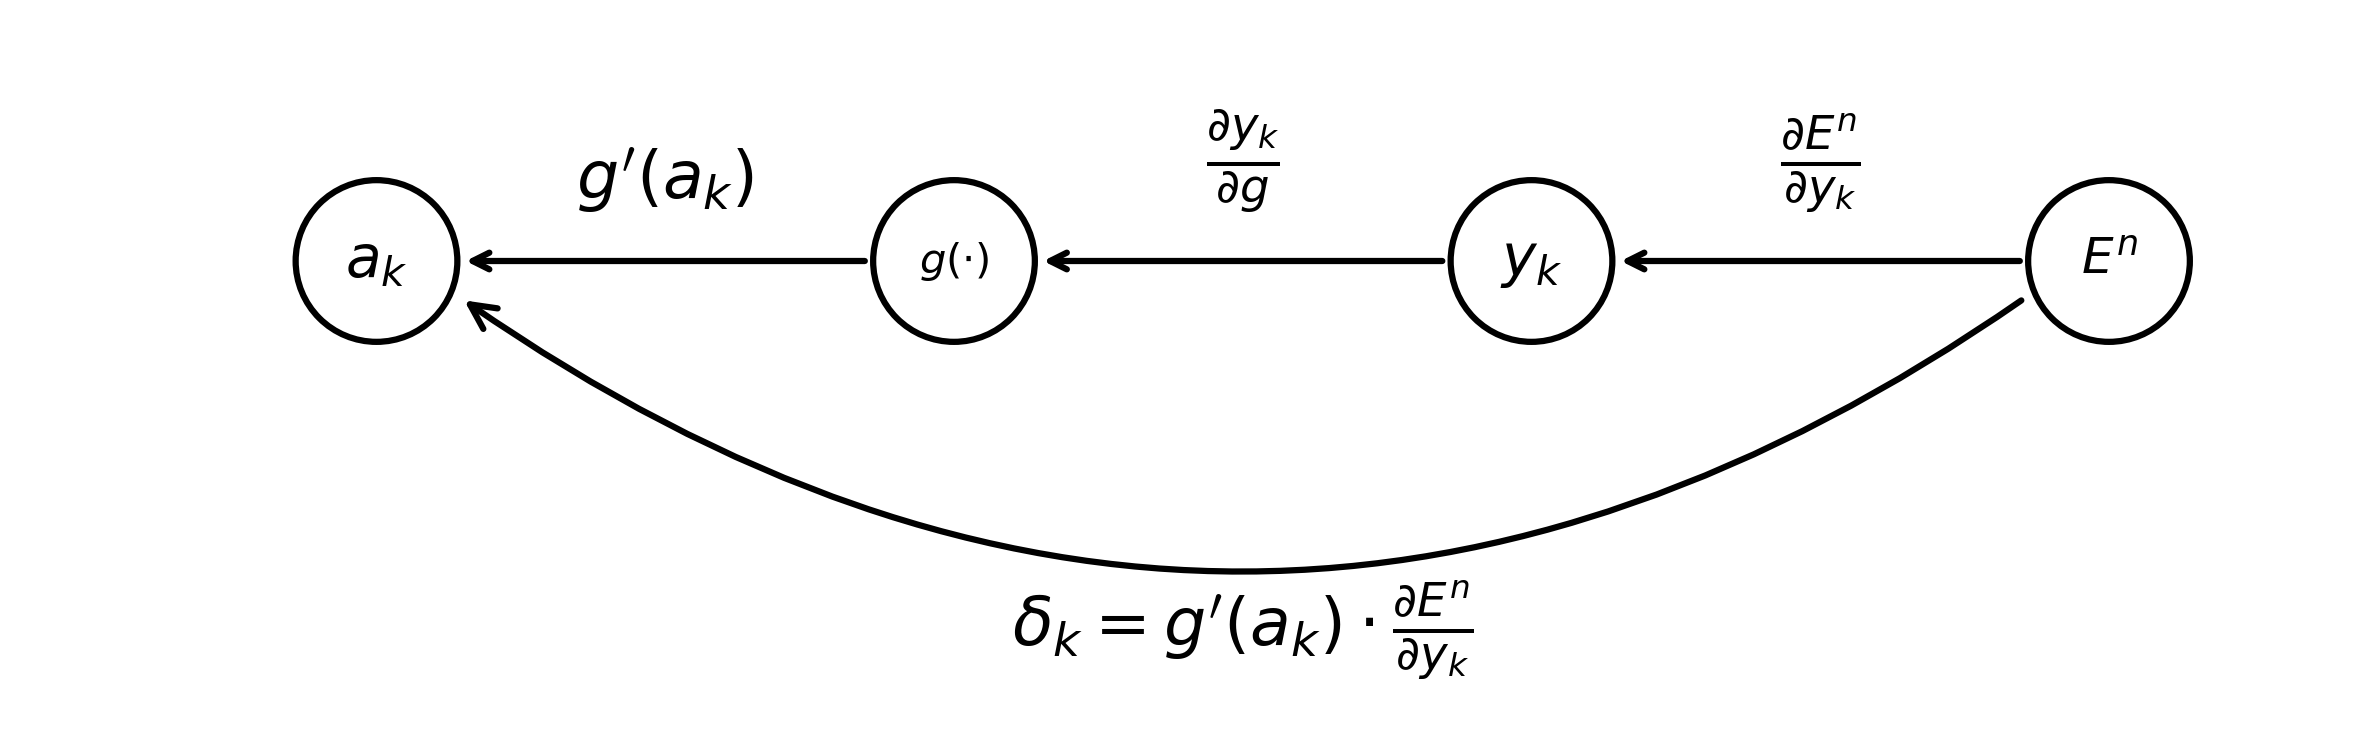

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(1, 1, figsize=(8, 3.5), dpi=300)
ax.set_xlim(-1, 9)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35  # node radius

# --- Node positions (horizontal line) ---
ak_pos = (0.5, 0.5)
gk_pos = (3.0, 0.5)
yk_pos = (5.5, 0.5)
en_pos = (8.0, 0.5)

# --- Helper: draw a circle with text ---
def draw_node(x, y, text, fontsize=16):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

# --- Draw nodes ---
draw_node(*ak_pos, r'$a_k$', fontsize=14)
draw_node(*gk_pos, r'$g(\cdot)$', fontsize=10)
draw_node(*yk_pos, r'$y_k$', fontsize=14)
draw_node(*en_pos, r'$E^n$', fontsize=12)

# --- Straight arrows: E^n -> y_k -> g -> a_k (gradient flow, right to left) ---
ax.annotate('', xy=(yk_pos[0] + r, yk_pos[1]), xytext=(en_pos[0] - r, en_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax.annotate('', xy=(gk_pos[0] + r, gk_pos[1]), xytext=(yk_pos[0] - r, yk_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax.annotate('', xy=(ak_pos[0] + r, ak_pos[1]), xytext=(gk_pos[0] - r, gk_pos[1]),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

# --- Labels on straight arrows ---
ax.text(6.75, 0.7, r'$\frac{\partial E^n}{\partial y_k}$',
        ha='center', va='bottom', fontsize=16)
ax.text(4.25, 0.7, r'$\frac{\partial y_k}{\partial g}$',
        ha='center', va='bottom', fontsize=16)
ax.text(1.75, 0.7, r'$g^\prime(a_k)$',
        ha='center', va='bottom', fontsize=16)

# --- Curved arrow: E^n -> a_k (underneath) ---
arc = FancyArrowPatch(
    (en_pos[0] - r, en_pos[1] - 0.15),
    (ak_pos[0] + r, ak_pos[1] - 0.15),
    connectionstyle="arc3,rad=-0.35",
    arrowstyle='->', color='black', lw=1.5, zorder=2,
    mutation_scale=15
)
ax.add_patch(arc)

# --- Label on curved arrow ---
ax.text(4.25, -1.1, r'$\delta_k = g^\prime(a_k) \cdot \frac{\partial E^n}{\partial y_k}$',
        ha='center', va='center', fontsize=16, color='black')

plt.tight_layout()
plt.savefig("assets/img/ml-concepts/backprop/backwards_inuit", dpi=300)
plt.show()

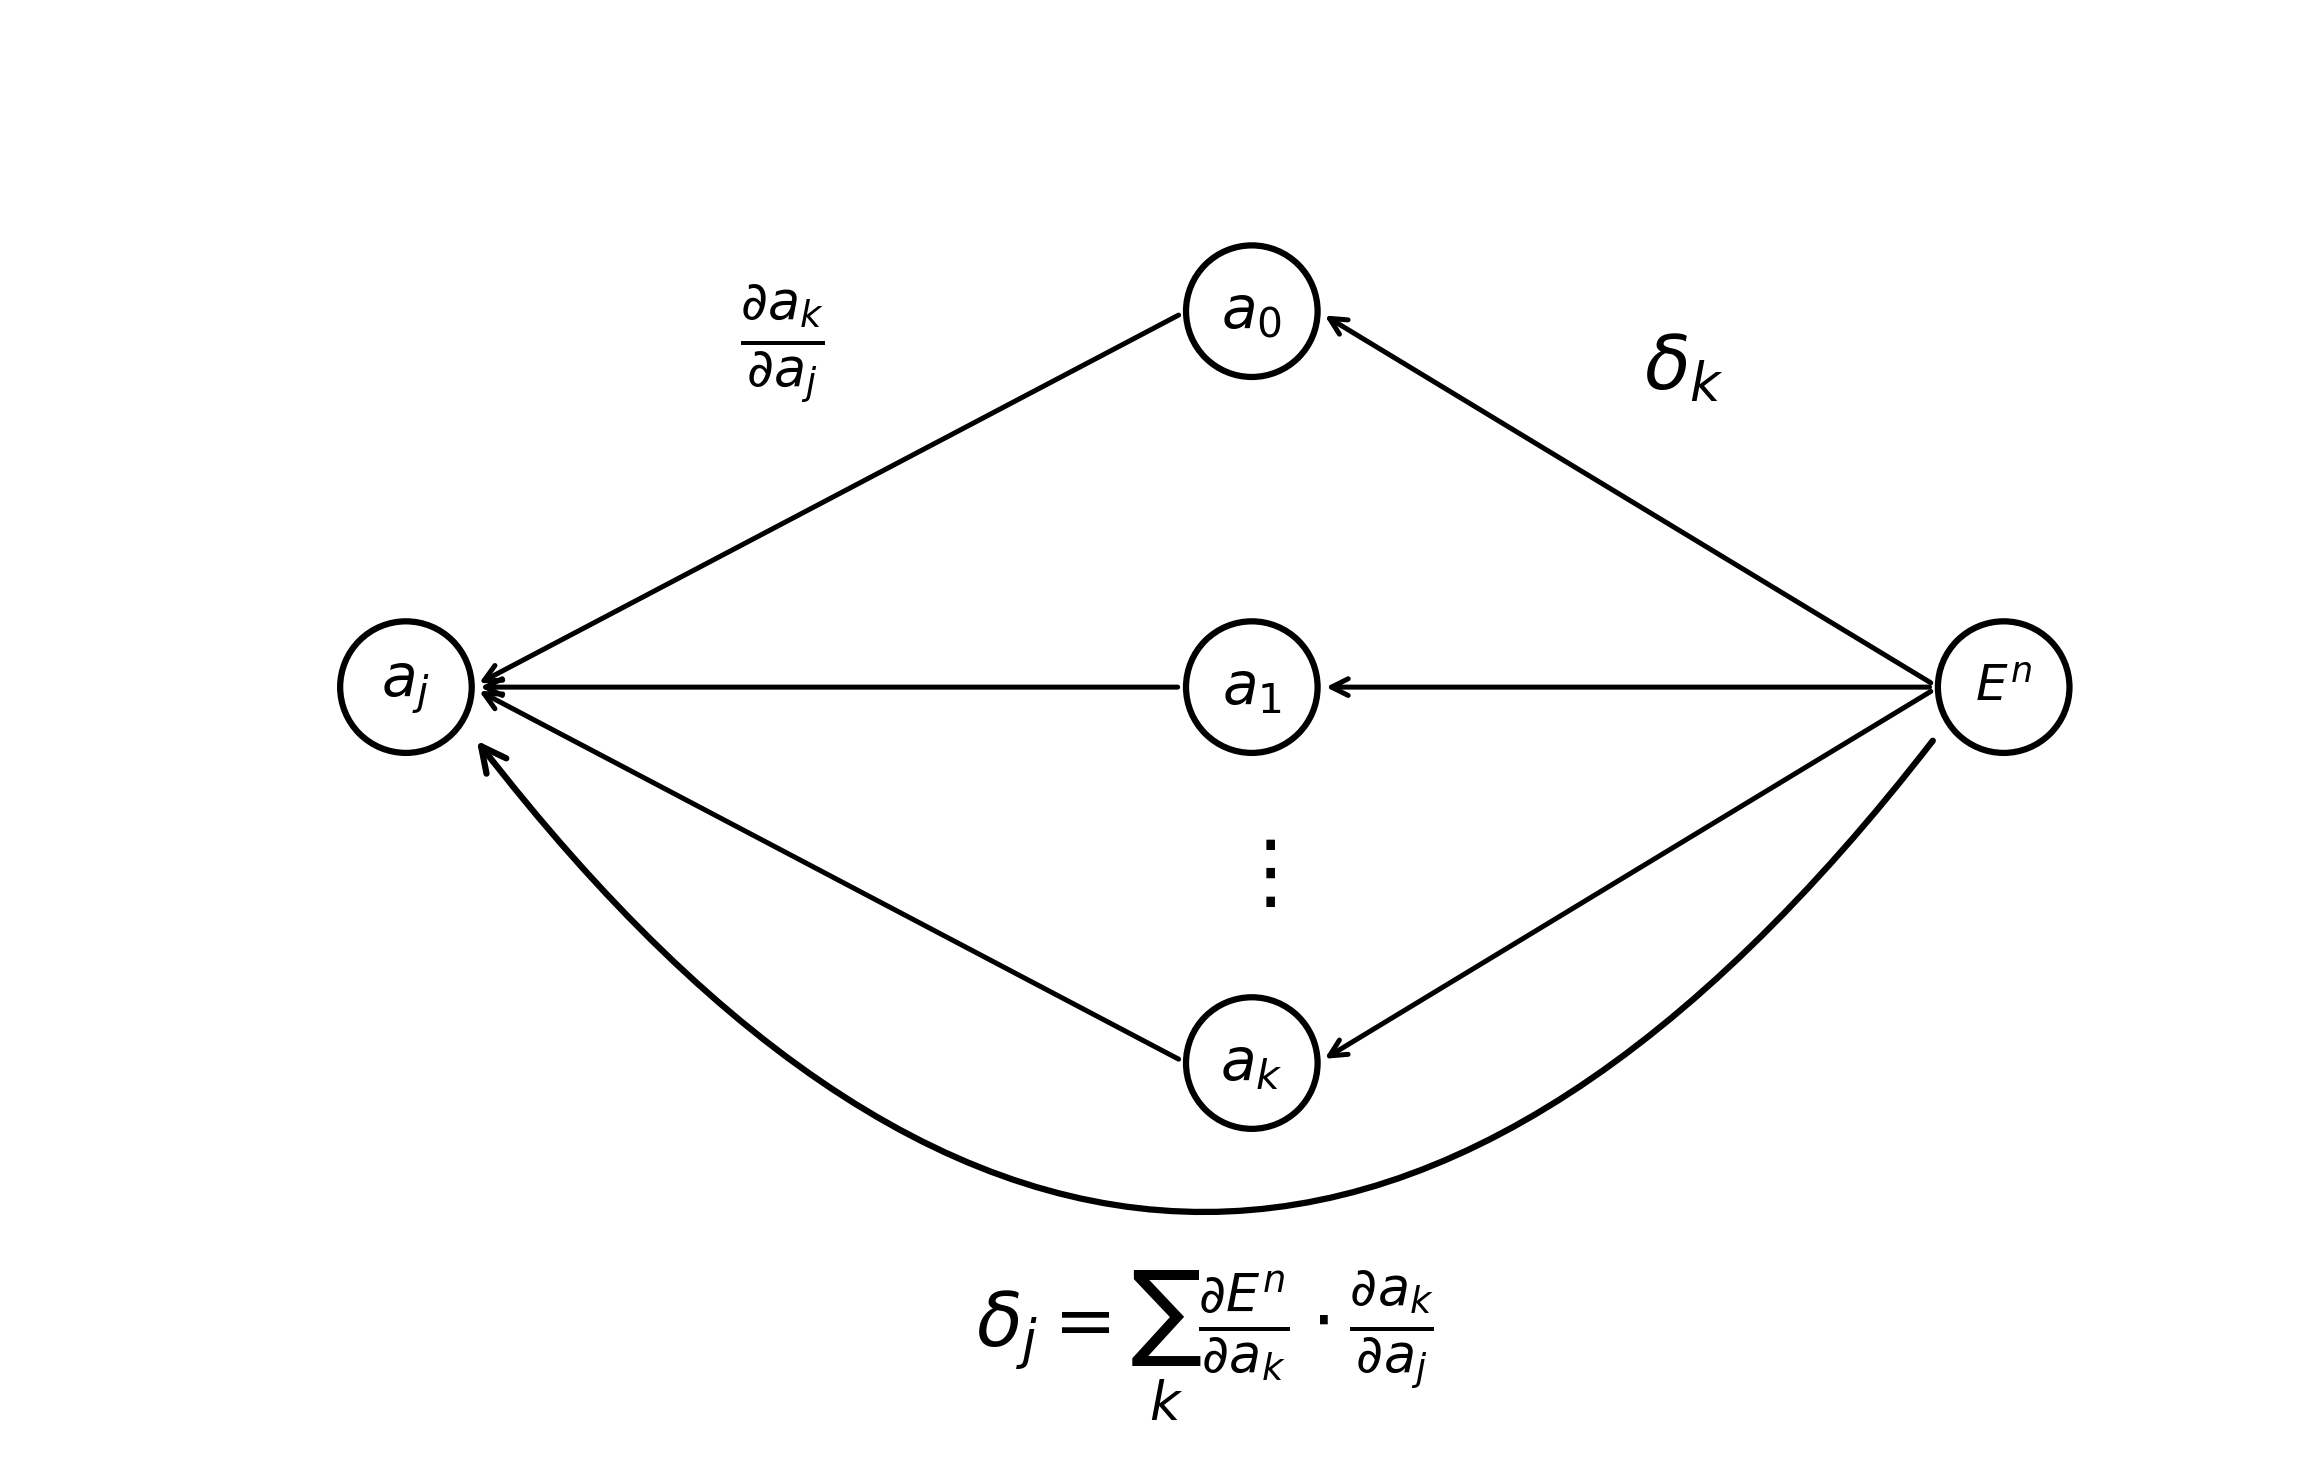

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
ax.set_xlim(-1, 11)
ax.set_ylim(-2.5, 5)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35  # node radius

# --- Node positions ---
aj_pos = (1.0, 1.5)  # hidden pre-activation (left)

# Output pre-activations (column, middle)
ak_ys = [3.5, 1.5, -0.5]  # a_0, a_1, a_k
ak_x = 5.5
ak_labels = [r'$a_0$', r'$a_1$', r'$a_k$']

en_pos = (9.5, 1.5)  # E^n (right)

# --- Helper: draw a circle with text ---
def draw_node(x, y, text, fontsize=16):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

# --- Draw nodes ---
draw_node(*aj_pos, r'$a_j$', fontsize=14)
for y, label in zip(ak_ys, ak_labels):
    draw_node(ak_x, y, label, fontsize=14)
# vdots between a_1 and a_k
ax.text(ak_x, 0.5, r'$\vdots$', ha='center', va='center', fontsize=20)
draw_node(*en_pos, r'$E^n$', fontsize=12)

# --- Arrows: E^n -> each a_k (gradient flow, right to left) ---
for y in ak_ys:
    ax.annotate('', xy=(ak_x + r, y), xytext=(en_pos[0] - r, en_pos[1]),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.2))

# --- Labels: delta_k on E^n -> a_k arrows ---
ax.text(7.8, 3.0, r'$\delta_k$', ha='center', va='bottom', fontsize=18, color='black')

# --- Arrows: each a_k -> a_j ---
for y in ak_ys:
    ax.annotate('', xy=(aj_pos[0] + r, aj_pos[1]), xytext=(ak_x - r, y),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.2))

# --- Label on a_k -> a_j arrows ---
ax.text(3.0, 3.0, r'$\frac{\partial a_k}{\partial a_j}$',
        ha='center', va='bottom', fontsize=18, color='black')

# --- Curved arrow: E^n -> a_j (underneath, summary) ---
arc = FancyArrowPatch(
    (en_pos[0] - r, en_pos[1] - 0.25),
    (aj_pos[0] + r, aj_pos[1] - 0.25),
    connectionstyle="arc3,rad=-.65",
    arrowstyle='->', color='#000000', lw=1.5, zorder=2,
    mutation_scale=15
)
ax.add_patch(arc)

# --- Label on curved arrow ---
ax.text(5.25, -2.0,
        r'$\delta_j = \sum_{k} \frac{\partial E^n}{\partial a_k} \cdot \frac{\partial a_k}{\partial a_j}$',
        ha='center', va='center', fontsize=18, color='#000000')

plt.tight_layout()
plt.show()

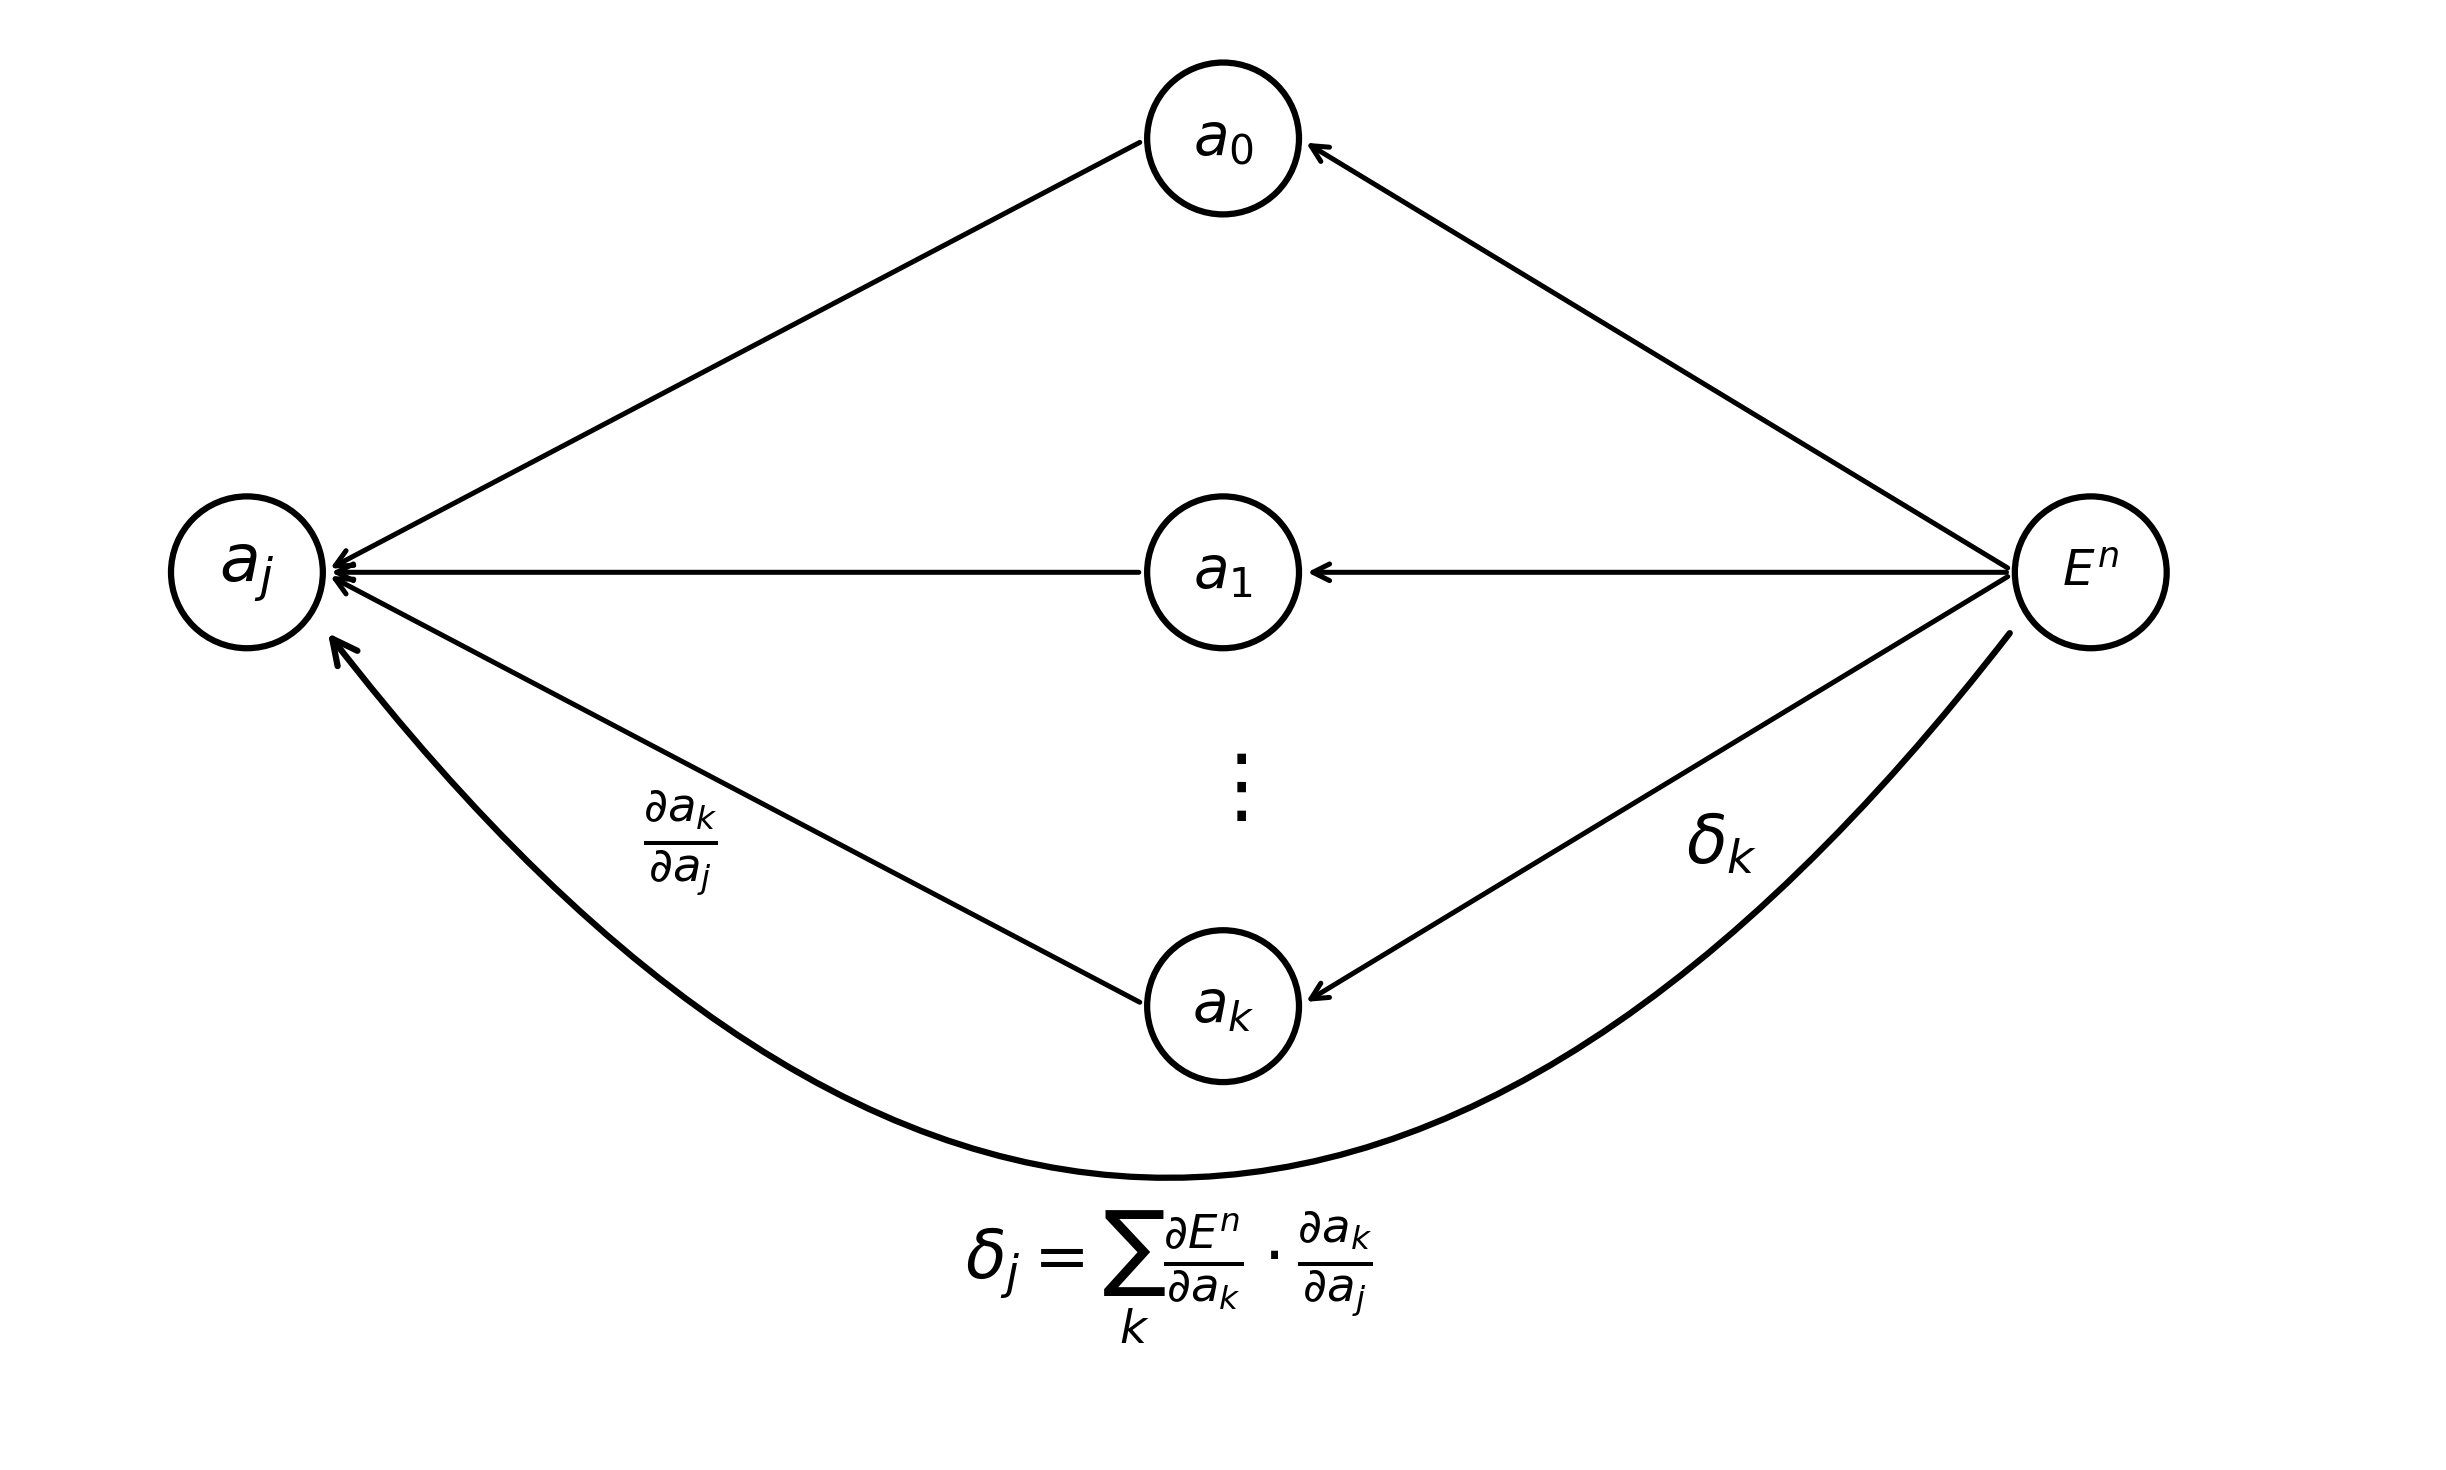

In [98]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
ax.set_xlim(0, 11)
ax.set_ylim(-2.5, 4)
ax.set_aspect('equal')
ax.axis('off')

r = 0.35  # node radius

# --- Node positions ---
aj_pos = (1.0, 1.5)  # hidden pre-activation (left)

# Output pre-activations (column, middle)
ak_ys = [3.5, 1.5, -0.5]  # a_0, a_1, a_k
ak_x = 5.5
ak_labels = [r'$a_0$', r'$a_1$', r'$a_k$']

en_pos = (9.5, 1.5)  # E^n (right)

# --- Helper: draw a circle with text ---
def draw_node(x, y, text, fontsize=16):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='black', linewidth=1.5, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, zorder=4)

# --- Draw nodes ---
draw_node(*aj_pos, r'$a_j$', fontsize=16)
for y, label in zip(ak_ys, ak_labels):
    draw_node(ak_x, y, label, fontsize=14)
# vdots between a_1 and a_k
ax.text(ak_x, 0.5, r'$\vdots$', ha='center', va='center', fontsize=20)
draw_node(*en_pos, r'$E^n$', fontsize=12)

# --- Arrows: E^n -> each a_k (gradient flow, right to left) ---
for y in ak_ys:
    ax.annotate('', xy=(ak_x + r, y), xytext=(en_pos[0] - r, en_pos[1]),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.2))

# --- Labels: delta_k on E^n -> a_k arrows ---
ax.text(7.8, .4, r'$\delta_k$', ha='center', va='top', fontsize=16, color='black')

# --- Arrows: each a_k -> a_j ---
for y in ak_ys:
    ax.annotate('', xy=(aj_pos[0] + r, aj_pos[1]), xytext=(ak_x - r, y),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.2))

# --- Label on a_k -> a_j arrows ---
ax.text(3.0, .5, r'$\frac{\partial a_k}{\partial a_j}$',
        ha='center', va='top', fontsize=16, color='black')

# --- Curved arrow: E^n -> a_j (underneath, summary) ---
arc = FancyArrowPatch(
    (en_pos[0] - r, en_pos[1] - 0.25),
    (aj_pos[0] + r, aj_pos[1] - 0.25),
    connectionstyle="arc3,rad=-0.65",
    arrowstyle='->', color='#000000', lw=1.5, zorder=2,
    mutation_scale=15
)
ax.add_patch(arc)

# --- Label on curved arrow ---
ax.text(5.25, -1.75,
        r'$\delta_j = \sum_{k} \frac{\partial E^n}{\partial a_k} \cdot \frac{\partial a_k}{\partial a_j}$',
        ha='center', va='center', fontsize=16, color='#000000')

plt.tight_layout()
plt.show()

Back-Propagation
1. For a vector input $\mathbf{x}$ and a neural network $\text{MLP}$, perform a **forward pass** to calculate all activations $z$ in the hidden and output layer.
2. Use (Eq. 4) to calculate all $\delta_k$ in the output layer.
3. "Backpropagate $\delta \text{'s}$ to calculate all $\delta_j$".
4. Evalulate (Eq. 3) at all weights.

$$
\begin{equation} \tag{7}
    \frac{\partial E}{w_{ji}} = \sum_{n} \frac{\partial E^n}{\partial w_{ji}}
\end{equation}
$$